In [1]:
import os
import logging
import dill as pickle
import urllib
import random
from tqdm import tqdm
import sys
import codecs
import spacy
import time

import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tarfile
import torchtext.data
import torchtext.datasets

import argparse

In [2]:
device = torch.device("cuda", index=2)
output_dir = './output_lambda=1.0'
lambda_ = 1.0

In [3]:
_TRAIN_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/" \
             "training-parallel-nc-v12.tgz",
     "trg": "news-commentary-v12.de-en.en",
     "src": "news-commentary-v12.de-en.de"}
    ]

_VAL_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/dev.tgz",
     "trg": "newstest2013.en",
     "src": "newstest2013.de"}]

_TEST_DATA_SOURCES = [
    {"url": "https://storage.googleapis.com/tf-perf-public/" \
                "official_transformer/test_data/newstest2014.tgz",
     "trg": "newstest2014.en",
     "src": "newstest2014.de"}]

In [4]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def file_exist(dir_name, file_name):
    for sub_dir, _, files in os.walk(dir_name):
        if file_name in files:
            return os.path.join(sub_dir, file_name)
    return None

In [5]:
def download_and_extract(download_dir, url, src_filename, trg_filename):
    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        sys.stderr.write(f"Already downloaded and extracted {url}.\n")
        return src_path, trg_path

    compressed_file = _download_file(download_dir, url)

    sys.stderr.write(f"Extracting {compressed_file}.\n")
    with tarfile.open(compressed_file, "r:gz") as corpus_tar:
        corpus_tar.extractall(download_dir)

    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        return src_path, trg_path

    raise OSError(f"Download/extraction failed for url {url} to path {download_dir}")

def _download_file(download_dir, url):
    filename = url.split("/")[-1]
    if file_exist(download_dir, filename):
        sys.stderr.write(f"Already downloaded: {url} (at {filename}).\n")
    else:
        sys.stderr.write(f"Downloading from {url} to {filename}.\n")
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, filename=filename, reporthook=t.update_to)
    return filename

def get_raw_files(raw_dir, sources):
    raw_files = { "src": [], "trg": [], }
    for d in sources:
        src_file, trg_file = download_and_extract(raw_dir, d["url"], d["src"], d["trg"])
        raw_files["src"].append(src_file)
        raw_files["trg"].append(trg_file)
    return raw_files

In [6]:
def mkdir_if_needed(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)

In [7]:
def compile_files(raw_dir, raw_files, prefix):
    src_fpath = os.path.join(raw_dir, f"raw-{prefix}.src")
    trg_fpath = os.path.join(raw_dir, f"raw-{prefix}.trg")

    if os.path.isfile(src_fpath) and os.path.isfile(trg_fpath):
        sys.stderr.write(f"Merged files found, skip the merging process.\n")
        return src_fpath, trg_fpath

    sys.stderr.write(f"Merge files into two files: {src_fpath} and {trg_fpath}.\n")

    with open(src_fpath, 'w') as src_outf, open(trg_fpath, 'w') as trg_outf:
        for src_inf, trg_inf in zip(raw_files['src'], raw_files['trg']):
            sys.stderr.write(f'  Input files: \n'\
                    f'    - SRC: {src_inf}, and\n' \
                    f'    - TRG: {trg_inf}.\n')
            with open(src_inf, newline='\n') as src_inf, open(trg_inf, newline='\n') as trg_inf:
                cntr = 0
                for i, line in enumerate(src_inf):
                    cntr += 1
                    src_outf.write(line.replace('\r', ' ').strip() + '\n')
                for j, line in enumerate(trg_inf):
                    cntr -= 1
                    trg_outf.write(line.replace('\r', ' ').strip() + '\n')
                assert cntr == 0, 'Number of lines in two files are inconsistent.'
    return src_fpath, trg_fpath

In [8]:
def encode_file(bpe, in_file, out_file):
    sys.stderr.write(f"Read raw content from {in_file} and \n"\
            f"Write encoded content to {out_file}\n")
    
    with codecs.open(in_file, encoding='utf-8') as in_f:
        with codecs.open(out_file, 'w', encoding='utf-8') as out_f:
            for line in in_f:
                out_f.write(bpe.process_line(line))

def encode_files(bpe, src_in_file, trg_in_file, data_dir, prefix):
    src_out_file = os.path.join(data_dir, f"{prefix}.src")
    trg_out_file = os.path.join(data_dir, f"{prefix}.trg")

    if os.path.isfile(src_out_file) and os.path.isfile(trg_out_file):
        sys.stderr.write(f"Encoded files found, skip the encoding process ...\n")

    encode_file(bpe, src_in_file, src_out_file)
    encode_file(bpe, trg_in_file, trg_out_file)
    return src_out_file, trg_out_file

In [9]:
src_lang_model = spacy.load('de_core_news_sm')
trg_lang_model = spacy.load('en_core_web_sm')

In [10]:
PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [11]:
def tokenize_src(text):
        return [tok.text for tok in src_lang_model.tokenizer(text)]

def tokenize_trg(text):
    return [tok.text for tok in trg_lang_model.tokenizer(text)]

SRC = torchtext.legacy.data.Field(
    tokenize=tokenize_src, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

TRG = torchtext.legacy.data.Field(
    tokenize=tokenize_trg, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

In [12]:
MAX_LEN = 100
MIN_FREQ = 3

In [13]:
def filter_examples_with_length(x):
    return len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN

In [14]:
ROOT = '../Datasets/Multi30k/'
train, val, test = torchtext.legacy.datasets.Multi30k.splits(
            root=ROOT,
            exts = ('.' + 'de', '.' + 'en'),
            fields = (SRC, TRG),
            filter_pred=filter_examples_with_length)

In [15]:
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
print('[Info] Get source language vocabulary size:', len(SRC.vocab))
TRG.build_vocab(train.trg, min_freq=MIN_FREQ)
print('[Info] Get target language vocabulary size:', len(TRG.vocab))

[Info] Get source language vocabulary size: 5374
[Info] Get target language vocabulary size: 4556


In [16]:
print('[Info] Merging two vocabulary ...')
for w, _ in SRC.vocab.stoi.items():
    if w not in TRG.vocab.stoi:
        TRG.vocab.stoi[w] = len(TRG.vocab.stoi)
TRG.vocab.itos = [None] * len(TRG.vocab.stoi)
for w, i in TRG.vocab.stoi.items():
    TRG.vocab.itos[i] = w
SRC.vocab.stoi = TRG.vocab.stoi
SRC.vocab.itos = TRG.vocab.itos
print('[Info] Get merged vocabulary size:', len(TRG.vocab))

[Info] Merging two vocabulary ...
[Info] Get merged vocabulary size: 9521


In [17]:
spacy_support_langs = ['de', 'el', 'en', 'es', 'fr', 'it', 'lt', 'nb', 'nl', 'pt']

parser = argparse.ArgumentParser()
parser.add_argument('-lang_src', required=True, choices=spacy_support_langs)
parser.add_argument('-lang_trg', required=True, choices=spacy_support_langs)
parser.add_argument('-save_data', required=True)
parser.add_argument('-data_src', type=str, default=None)
parser.add_argument('-data_trg', type=str, default=None)

parser.add_argument('-max_len', type=int, default=100)
parser.add_argument('-min_word_count', type=int, default=3)
parser.add_argument('-keep_case', action='store_true')
parser.add_argument('-share_vocab', action='store_true')

opt = parser.parse_args(args=['-lang_src', 'de', '-lang_trg', 'en', '-share_vocab', '-save_data', './m30k_deen_shr.pkl'])

In [18]:
data = {
    'settings': opt,
    'vocab': {'src': SRC, 'trg': TRG},
    'train': train.examples,
    'valid': val.examples,
    'test': test.examples}

print('[Info] Dumping the processed data to pickle file', opt.save_data)
pickle.dump(data, open(opt.save_data, 'wb'))

[Info] Dumping the processed data to pickle file ./m30k_deen_shr.pkl


# 学習設定

In [19]:
parser = argparse.ArgumentParser()

parser.add_argument('-data_pkl', default=None)     # all-in-1 data pickle or bpe field
parser.add_argument('-train_path', default=None)   # bpe encoded data
parser.add_argument('-val_path', default=None)     # bpe encoded data
parser.add_argument('-epoch', type=int, default=10)
parser.add_argument('-b', '--batch_size', type=int, default=2048)
parser.add_argument('-d_model', type=int, default=512)
parser.add_argument('-d_inner_hid', type=int, default=2048)
parser.add_argument('-d_k', type=int, default=64)
parser.add_argument('-d_v', type=int, default=64)
parser.add_argument('-n_head', type=int, default=8)
parser.add_argument('-n_layers', type=int, default=6)
parser.add_argument('-warmup','--n_warmup_steps', type=int, default=4000)
parser.add_argument('-lr_mul', type=float, default=2.0)
parser.add_argument('-seed', type=int, default=None)
parser.add_argument('-dropout', type=float, default=0.1)
parser.add_argument('-embs_share_weight', action='store_true')
parser.add_argument('-proj_share_weight', action='store_true')
parser.add_argument('-scale_emb_or_prj', type=str, default='prj')
parser.add_argument('-output_dir', type=str, default=None)
parser.add_argument('-use_tb', action='store_true')
parser.add_argument('-save_mode', type=str, choices=['all', 'best'], default='best')
parser.add_argument('-no_cuda', action='store_true')
parser.add_argument('-label_smoothing', action='store_true')

opt = parser.parse_args(
    args=['-data_pkl', './m30k_deen_shr.pkl', '-seed', '428', '-embs_share_weight', '-proj_share_weight', '-label_smoothing', '-output_dir', output_dir, '-b', '512', '-warmup', '128000', '-epoch', '1000'])
opt.cuda = not opt.no_cuda
opt.d_word_vec = opt.d_model

In [20]:
if opt.seed is not None:
    torch.manual_seed(opt.seed)
    torch.backends.cudnn.benchmark = False
    np.random.seed(opt.seed)
    random.seed(opt.seed)

In [21]:
if opt.batch_size < 2048 and opt.n_warmup_steps <= 4000:
    print('[Warning] The warmup steps may be not enough.\n'\
            '(sz_b, warmup) = (2048, 4000) is the official setting.\n'\
            'Using smaller batch w/o longer warmup may cause '\
            'the warmup stage ends with only little data trained.')

In [22]:
def prepare_dataloaders(opt, device):
    batch_size = opt.batch_size
    data = pickle.load(open(opt.data_pkl, 'rb'))

    opt.max_token_seq_len = data['settings'].max_len
    opt.src_pad_idx = data['vocab']['src'].vocab.stoi[PAD_WORD]
    opt.trg_pad_idx = data['vocab']['trg'].vocab.stoi[PAD_WORD]

    opt.src_vocab_size = len(data['vocab']['src'].vocab)
    opt.trg_vocab_size = len(data['vocab']['trg'].vocab)

    if opt.embs_share_weight:
        assert data['vocab']['src'].vocab.stoi == data['vocab']['trg'].vocab.stoi, \
            'To sharing word embedding the src/trg word2idx table shall be the same.'

    fields = {'src': data['vocab']['src'], 'trg':data['vocab']['trg']}

    train = torchtext.legacy.data.Dataset(examples=data['train'], fields=fields)
    val = torchtext.legacy.data.Dataset(examples=data['valid'], fields=fields)

    train_iterator = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size, device=device, train=True)
    val_iterator = torchtext.legacy.data.BucketIterator(val, batch_size=batch_size, device=device)

    return train_iterator, val_iterator

In [23]:
training_data, validation_data = prepare_dataloaders(opt, device)

# Gate 付き Transformer の実装と実体化

In [24]:
class BinaryGate(nn.Module):
    
    def __init__(self, num_gates: int, init: float=0.0):
        super(BinaryGate, self).__init__()
        
        self.num_gates = num_gates
        self.gate = nn.parameter.Parameter(torch.zeros(num_gates).fill_(init))
    
    def forward(self, beta=0.667, gamma=-0.1, zeta = 1.0, 
                hard = True, eps = 1e-6, threshold=0.5):
        
        loss_constant = (beta * math.log(-gamma / zeta)) if (gamma < 0) else 0.0
        
        if self.training:
            noise = torch.zeros(self.num_gates)
            noise = noise.cuda(self.gate.device)
            
            noise.data.uniform_(eps, 1 - eps)
            u = noise.data
            
            s = torch.log(u) - torch.log(1.0 - u)
            
            s = (s + self.gate) / beta
            s = torch.sigmoid(s)
        else:
            s = torch.sigmoid(self.gate)
        
        s = s * (zeta - gamma) + gamma
        out = torch.clamp(s, eps, 1)
        
        if hard:
            out_hard = torch.greater_equal(out, threshold).float()
            out = out + (out_hard - out).detach()
            sparsity = torch.eq(out, 0).sum()
        else:
            sparsity = torch.less(out, threshold).float().sum()
        
        l0_loss = torch.sigmoid(self.gate - loss_constant)
        l0_loss = torch.clamp(l0_loss, eps, 1.0 - eps).sum()
        
        return out, l0_loss, (sparsity.detach().cpu(), self.num_gates)

In [25]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

In [26]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.gate = BinaryGate(num_gates=n_head, init=2.0)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        
        bin_mask, l0_loss, sparsity = self.gate()
        bin_mask = torch.cat([bin_mask[i].repeat(self.d_model//self.n_head) for i in range(self.n_head)])
        
        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)
        
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q *= bin_mask
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn, l0_loss, sparsity


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [27]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn, l0_loss, sparsity = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        
        return enc_output, enc_slf_attn, l0_loss, sparsity


class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn, l0_loss1, sparsity1 = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn, l0_loss2, sparsity2 = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        
        return dec_output, dec_slf_attn, dec_enc_attn, l0_loss1+l0_loss2, sparsity1, sparsity2

In [28]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []
        l0_loss = 0.0
        sparsity = [0, 0]
        
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn, l0, spa = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            l0_loss += l0
            sparsity[0] += spa[0]
            sparsity[1] += spa[1]

        if return_attns:
            return enc_output, l0_loss, sparsity, enc_slf_attn_list
        return enc_output, l0_loss, sparsity,


class Decoder(nn.Module):

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []
        l0_loss = 0.0
        sparsity1 = [0, 0]
        sparsity2 = [0, 0]
        
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn, l0, spa1, spa2 = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
            l0_loss += l0
            sparsity1[0] += spa1[0]
            sparsity1[1] += spa1[1]
            sparsity2[0] += spa2[0]
            sparsity2[1] += spa2[1]

        if return_attns:
            return dec_output, l0_loss, sparsity1, sparsity2, dec_slf_attn_list, dec_enc_attn_list
        return dec_output, l0_loss, sparsity1, sparsity2,

In [29]:
class Transformer(nn.Module):

    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):

        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, l0_loss1, sparsity1, *_ = self.encoder(src_seq, src_mask)
        dec_output, l0_loss2, sparsity2, sparsity3, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        return seq_logit.view(-1, seq_logit.size(2)), l0_loss1+l0_loss2, (sparsity1, sparsity2, sparsity3)

In [30]:
transformer = Transformer(
        opt.src_vocab_size,
        opt.trg_vocab_size,
        src_pad_idx=opt.src_pad_idx,
        trg_pad_idx=opt.trg_pad_idx,
        trg_emb_prj_weight_sharing=opt.proj_share_weight,
        emb_src_trg_weight_sharing=opt.embs_share_weight,
        d_k=opt.d_k,
        d_v=opt.d_v,
        d_model=opt.d_model,
        d_word_vec=opt.d_word_vec,
        d_inner=opt.d_inner_hid,
        n_layers=opt.n_layers,
        n_head=opt.n_head,
        dropout=opt.dropout,
        scale_emb_or_prj=opt.scale_emb_or_prj).to(device)

# Optimizer の実装と実体化

In [31]:
class ScheduledOptim():

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [32]:
optimizer = ScheduledOptim(
        optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        opt.lr_mul, opt.d_model, opt.n_warmup_steps)

# 訓練と検証

In [33]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word


def cal_loss(pred, gold, trg_pad_idx, smoothing=False):

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss


def patch_src(src, pad_idx):
    src = src.transpose(0, 1)
    return src


def patch_trg(trg, pad_idx):
    trg = trg.transpose(0, 1)
    trg, gold = trg[:, :-1], trg[:, 1:].contiguous().view(-1)
    return trg, gold


def train_epoch(model, training_data, optimizer, opt, device, smoothing, lambda_):

    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 
    enc_sparsity = [0, 0]
    dec_sparsity1 = [0, 0]
    dec_sparsity2 = [0, 0]
    
    desc = '  - (Training)   '
    for batch in tqdm(training_data, mininterval=2, desc=desc, leave=False):
        
        src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
        trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

        # forward
        optimizer.zero_grad()
        pred, l0_loss, sparsity = model(src_seq, trg_seq)

        # backward and update parameters
        loss, n_correct, n_word = cal_performance(
            pred, gold, opt.trg_pad_idx, smoothing=smoothing)
        loss_ = loss + lambda_ * l0_loss
        loss_.backward()
        optimizer.step_and_update_lr()

        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()
        enc_sparsity[0] += sparsity[0][0]
        enc_sparsity[1] += sparsity[0][1]
        dec_sparsity1[0] += sparsity[1][0]
        dec_sparsity1[1] += sparsity[1][1]
        dec_sparsity2[0] += sparsity[2][0]
        dec_sparsity2[1] += sparsity[2][1]
        

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy, (enc_sparsity, dec_sparsity1, dec_sparsity2)


def eval_epoch(model, validation_data, device, opt, lambda_):

    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0

    desc = '  - (Validation) '
    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):

            # prepare data
            src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
            trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

            # forward
            pred, l0_loss, sparsity = model(src_seq, trg_seq)
            loss, n_correct, n_word = cal_performance(
                pred, gold, opt.trg_pad_idx, smoothing=False)
            
            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

In [34]:
def train(model, training_data, validation_data, optimizer, device, opt, lambda_=0.0):
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')
    log_sparsity_file = os.path.join(opt.output_dir, 'sparsity.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file, log_sparsity_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf, open(log_sparsity_file, 'w') as log_sf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')
        log_sf.write('epoch,enc-sa,dec-sa, dec-enc\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu, sparsity = train_epoch(
            model, training_data, optimizer, opt, device, smoothing=opt.label_smoothing, lambda_=lambda_)
        train_ppl = math.exp(min(train_loss, 100))
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt, lambda_=lambda_)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf, open(log_sparsity_file, 'a') as log_sf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))
            log_sf.write('{epoch},{enc: 3.3f},{dec1: 3.3f},{dec2: 3.3f}\n'.format(
                epoch=epoch_i, 
                enc =(sparsity[0][1]-sparsity[0][0])/sparsity[0][1],
                dec1=(sparsity[1][1]-sparsity[1][0])/sparsity[1][1],
                dec2=(sparsity[2][1]-sparsity[2][0])/sparsity[2][1]))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)

In [35]:
train(transformer, training_data, validation_data, optimizer, device, opt, lambda_=lambda_)

[Info] Training performance will be written to file: ./output_lambda=1.0/train.log and ./output_lambda=1.0/valid.log
[ Epoch 0 ]


  - (Training)   ppl:  9500.33826, accuracy: 0.006 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  9474.57718, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   ppl:  9484.22100, accuracy: 0.012 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  9435.46182, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


  - (Training)   ppl:  9453.71184, accuracy: 0.848 %, lr:  0.00000, elapse: 0.306 min


  - (Validation) ppl:  9377.63548, accuracy: 11.981 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


  - (Training)   ppl:  9412.59618, accuracy: 6.186 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  9315.28115, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]


  - (Training)   ppl:  9361.59024, accuracy: 11.625 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9256.47094, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]


  - (Training)   ppl:  9316.18397, accuracy: 11.957 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  9202.75087, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]


  - (Training)   ppl:  9271.09247, accuracy: 12.014 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9155.00722, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   ppl:  9233.23838, accuracy: 12.015 %, lr:  0.00000, elapse: 0.308 min


  - (Validation) ppl:  9114.49368, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]


  - (Training)   ppl:  9198.37593, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  9078.45125, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]


  - (Training)   ppl:  9164.51258, accuracy: 12.015 %, lr:  0.00000, elapse: 0.321 min


  - (Validation) ppl:  9043.89195, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 10 ]


  - (Training)   ppl:  9132.23386, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  9012.63556, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 11 ]


  - (Training)   ppl:  9102.60194, accuracy: 12.015 %, lr:  0.00000, elapse: 0.320 min


  - (Validation) ppl:  8982.85033, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]


  - (Training)   ppl:  9071.91020, accuracy: 12.015 %, lr:  0.00000, elapse: 0.321 min


  - (Validation) ppl:  8953.86836, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 13 ]


  - (Training)   ppl:  9044.64769, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8925.93602, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 14 ]


  - (Training)   ppl:  9017.21016, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8897.96566, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 15 ]


  - (Training)   ppl:  8988.09261, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8869.34393, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 16 ]


  - (Training)   ppl:  8962.55160, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8840.30248, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 17 ]


  - (Training)   ppl:  8932.18473, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8809.66630, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 18 ]


  - (Training)   ppl:  8902.71441, accuracy: 12.015 %, lr:  0.00000, elapse: 0.320 min


  - (Validation) ppl:  8777.21759, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 19 ]


  - (Training)   ppl:  8870.91140, accuracy: 12.015 %, lr:  0.00000, elapse: 0.327 min


  - (Validation) ppl:  8742.37646, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 20 ]


  - (Training)   ppl:  8839.27516, accuracy: 12.015 %, lr:  0.00000, elapse: 0.326 min


  - (Validation) ppl:  8704.39059, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 21 ]


  - (Training)   ppl:  8802.35520, accuracy: 12.015 %, lr:  0.00000, elapse: 0.327 min


  - (Validation) ppl:  8661.26123, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 22 ]


  - (Training)   ppl:  8760.94081, accuracy: 12.015 %, lr:  0.00000, elapse: 0.325 min


  - (Validation) ppl:  8614.50428, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 23 ]


  - (Training)   ppl:  8719.30724, accuracy: 12.016 %, lr:  0.00000, elapse: 0.325 min


  - (Validation) ppl:  8565.91168, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 24 ]


  - (Training)   ppl:  8674.83583, accuracy: 12.159 %, lr:  0.00000, elapse: 0.324 min


  - (Validation) ppl:  8516.96647, accuracy: 13.864 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 25 ]


  - (Training)   ppl:  8628.27564, accuracy: 13.393 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  8463.36796, accuracy: 16.281 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 26 ]


  - (Training)   ppl:  8581.27950, accuracy: 15.131 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8406.95411, accuracy: 16.468 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 27 ]


  - (Training)   ppl:  8534.66757, accuracy: 15.925 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8361.91383, accuracy: 16.205 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 28 ]


  - (Training)   ppl:  8488.01193, accuracy: 16.341 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  8302.36179, accuracy: 17.161 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 29 ]


  - (Training)   ppl:  8439.26846, accuracy: 16.603 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8249.59606, accuracy: 17.639 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 30 ]


  - (Training)   ppl:  8391.79678, accuracy: 16.762 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8196.99273, accuracy: 17.431 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 31 ]


  - (Training)   ppl:  8343.36203, accuracy: 16.920 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8140.29744, accuracy: 17.749 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 32 ]


  - (Training)   ppl:  8293.54096, accuracy: 16.960 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8090.44807, accuracy: 17.722 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 33 ]


  - (Training)   ppl:  8242.87678, accuracy: 17.076 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8029.48579, accuracy: 17.729 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 34 ]


  - (Training)   ppl:  8191.57615, accuracy: 16.937 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  7969.74387, accuracy: 18.165 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 35 ]


  - (Training)   ppl:  8136.77885, accuracy: 17.071 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  7912.69368, accuracy: 17.784 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 36 ]


  - (Training)   ppl:  8081.78411, accuracy: 17.121 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  7847.09082, accuracy: 17.846 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 37 ]


  - (Training)   ppl:  8026.62782, accuracy: 17.043 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  7784.79432, accuracy: 17.929 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 38 ]


  - (Training)   ppl:  7969.32711, accuracy: 17.113 %, lr:  0.00000, elapse: 0.324 min


  - (Validation) ppl:  7722.30925, accuracy: 18.227 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 39 ]


  - (Training)   ppl:  7910.67359, accuracy: 17.082 %, lr:  0.00000, elapse: 0.329 min


  - (Validation) ppl:  7658.08181, accuracy: 17.479 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 40 ]


  - (Training)   ppl:  7850.64756, accuracy: 16.974 %, lr:  0.00000, elapse: 0.323 min


  - (Validation) ppl:  7589.48218, accuracy: 18.158 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 41 ]


  - (Training)   ppl:  7790.42341, accuracy: 16.991 %, lr:  0.00000, elapse: 0.323 min


  - (Validation) ppl:  7521.60896, accuracy: 18.068 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 42 ]


  - (Training)   ppl:  7728.61353, accuracy: 16.857 %, lr:  0.00000, elapse: 0.325 min


  - (Validation) ppl:  7453.30429, accuracy: 17.839 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 43 ]


  - (Training)   ppl:  7665.18788, accuracy: 16.909 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  7384.51514, accuracy: 18.096 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 44 ]


  - (Training)   ppl:  7600.89700, accuracy: 16.840 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  7316.71120, accuracy: 18.580 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 45 ]


  - (Training)   ppl:  7536.03917, accuracy: 16.647 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  7242.33415, accuracy: 18.033 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 46 ]


  - (Training)   ppl:  7469.09178, accuracy: 16.532 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  7166.96030, accuracy: 17.237 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 47 ]


  - (Training)   ppl:  7401.77498, accuracy: 16.475 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  7094.26097, accuracy: 16.170 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 48 ]


  - (Training)   ppl:  7334.22277, accuracy: 16.425 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  7017.91606, accuracy: 16.967 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 49 ]


  - (Training)   ppl:  7264.61355, accuracy: 16.525 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6941.86692, accuracy: 17.791 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 50 ]


  - (Training)   ppl:  7194.15756, accuracy: 16.248 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6864.71217, accuracy: 17.597 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 51 ]


  - (Training)   ppl:  7124.16230, accuracy: 16.144 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6788.02014, accuracy: 17.784 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 52 ]


  - (Training)   ppl:  7051.88356, accuracy: 15.977 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6711.45682, accuracy: 17.909 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 53 ]


  - (Training)   ppl:  6978.67189, accuracy: 15.942 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6630.81707, accuracy: 16.835 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 54 ]


  - (Training)   ppl:  6906.34041, accuracy: 15.820 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6551.21003, accuracy: 17.230 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 55 ]


  - (Training)   ppl:  6833.01565, accuracy: 15.795 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  6471.06710, accuracy: 16.704 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 56 ]


  - (Training)   ppl:  6758.50766, accuracy: 15.665 %, lr:  0.00001, elapse: 0.321 min


  - (Validation) ppl:  6390.61652, accuracy: 16.004 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 57 ]


  - (Training)   ppl:  6683.96075, accuracy: 15.365 %, lr:  0.00001, elapse: 0.321 min


  - (Validation) ppl:  6312.46379, accuracy: 13.878 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 58 ]


  - (Training)   ppl:  6608.73447, accuracy: 15.075 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  6228.49486, accuracy: 16.357 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 59 ]


  - (Training)   ppl:  6531.67715, accuracy: 15.035 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  6146.32788, accuracy: 16.288 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 60 ]


  - (Training)   ppl:  6455.22129, accuracy: 14.878 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6063.20411, accuracy: 15.699 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 61 ]


  - (Training)   ppl:  6377.76379, accuracy: 14.724 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  5981.07346, accuracy: 15.526 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 62 ]


  - (Training)   ppl:  6301.95232, accuracy: 14.451 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  5898.55363, accuracy: 15.699 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 63 ]


  - (Training)   ppl:  6223.54166, accuracy: 14.330 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  5814.99953, accuracy: 13.733 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 64 ]


  - (Training)   ppl:  6145.34731, accuracy: 14.168 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  5732.41808, accuracy: 14.204 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 65 ]


  - (Training)   ppl:  6067.18530, accuracy: 13.925 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  5648.59307, accuracy: 13.788 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 66 ]


  - (Training)   ppl:  5989.31544, accuracy: 13.718 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5566.36575, accuracy: 13.089 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 67 ]


  - (Training)   ppl:  5911.11284, accuracy: 13.430 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  5482.20684, accuracy: 13.359 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 68 ]


  - (Training)   ppl:  5831.84335, accuracy: 13.324 %, lr:  0.00001, elapse: 0.325 min


  - (Validation) ppl:  5398.48202, accuracy: 12.832 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 69 ]


  - (Training)   ppl:  5753.02203, accuracy: 13.144 %, lr:  0.00001, elapse: 0.328 min


  - (Validation) ppl:  5316.43133, accuracy: 12.645 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 70 ]


  - (Training)   ppl:  5673.48970, accuracy: 12.979 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  5231.64654, accuracy: 12.202 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 71 ]


  - (Training)   ppl:  5594.93467, accuracy: 12.789 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5148.61777, accuracy: 12.798 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 72 ]


  - (Training)   ppl:  5517.00765, accuracy: 12.641 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  5066.57638, accuracy: 12.084 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 73 ]


  - (Training)   ppl:  5436.74110, accuracy: 12.543 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4984.62991, accuracy: 12.071 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 74 ]


  - (Training)   ppl:  5358.69190, accuracy: 12.494 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4900.63112, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 75 ]


  - (Training)   ppl:  5279.48860, accuracy: 12.365 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4818.23292, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 76 ]


  - (Training)   ppl:  5201.27560, accuracy: 12.317 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4736.52947, accuracy: 12.015 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 77 ]


  - (Training)   ppl:  5122.32111, accuracy: 12.250 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4656.51379, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 78 ]


  - (Training)   ppl:  5044.02475, accuracy: 12.158 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4574.00381, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 79 ]


  - (Training)   ppl:  4966.28372, accuracy: 12.159 %, lr:  0.00001, elapse: 0.325 min


  - (Validation) ppl:  4493.20379, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 80 ]


  - (Training)   ppl:  4888.88631, accuracy: 12.089 %, lr:  0.00001, elapse: 0.324 min


  - (Validation) ppl:  4412.22307, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 81 ]


  - (Training)   ppl:  4811.39958, accuracy: 12.097 %, lr:  0.00001, elapse: 0.327 min


  - (Validation) ppl:  4333.51886, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 82 ]


  - (Training)   ppl:  4733.96739, accuracy: 12.057 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  4254.02576, accuracy: 12.001 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 83 ]


  - (Training)   ppl:  4657.05512, accuracy: 12.060 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4175.23292, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 84 ]


  - (Training)   ppl:  4581.04616, accuracy: 12.046 %, lr:  0.00001, elapse: 0.319 min


  - (Validation) ppl:  4096.24918, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 85 ]


  - (Training)   ppl:  4505.00885, accuracy: 12.032 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4019.37714, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 86 ]


  - (Training)   ppl:  4429.75482, accuracy: 12.027 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  3942.75509, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 87 ]


  - (Training)   ppl:  4354.74432, accuracy: 12.022 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  3865.84583, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 88 ]


  - (Training)   ppl:  4280.28172, accuracy: 12.024 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3790.16200, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 89 ]


  - (Training)   ppl:  4206.15108, accuracy: 12.019 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  3715.29749, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 90 ]


  - (Training)   ppl:  4132.99777, accuracy: 12.018 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3640.73658, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 91 ]


  - (Training)   ppl:  4060.28490, accuracy: 12.016 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3568.84868, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 92 ]


  - (Training)   ppl:  3987.46306, accuracy: 12.016 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3495.75788, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 93 ]


  - (Training)   ppl:  3915.93039, accuracy: 12.016 %, lr:  0.00001, elapse: 0.323 min


  - (Validation) ppl:  3423.71200, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 94 ]


  - (Training)   ppl:  3844.92764, accuracy: 12.016 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  3352.47252, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 95 ]


  - (Training)   ppl:  3774.57298, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3282.32910, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 96 ]


  - (Training)   ppl:  3704.57967, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3213.10998, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 97 ]


  - (Training)   ppl:  3635.57023, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3144.23701, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 98 ]


  - (Training)   ppl:  3567.05618, accuracy: 12.015 %, lr:  0.00001, elapse: 0.329 min


  - (Validation) ppl:  3076.83699, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 99 ]


  - (Training)   ppl:  3499.41891, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  3009.59840, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 100 ]


  - (Training)   ppl:  3432.24712, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  2945.86297, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 101 ]


  - (Training)   ppl:  3366.39246, accuracy: 12.015 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  2879.53696, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 102 ]


  - (Training)   ppl:  3300.80999, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  2814.99210, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 103 ]


  - (Training)   ppl:  3236.34210, accuracy: 12.015 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  2752.18586, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 104 ]


  - (Training)   ppl:  3172.76802, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2690.53124, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 105 ]


  - (Training)   ppl:  3109.10180, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2628.59622, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 106 ]


  - (Training)   ppl:  3047.06055, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  2568.81993, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 107 ]


  - (Training)   ppl:  2985.78358, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2508.36788, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 108 ]


  - (Training)   ppl:  2924.82199, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2450.22647, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 109 ]


  - (Training)   ppl:  2865.06566, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  2393.02226, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 110 ]


  - (Training)   ppl:  2806.08896, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  2336.79386, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 111 ]


  - (Training)   ppl:  2747.93647, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  2280.96892, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 112 ]


  - (Training)   ppl:  2690.64164, accuracy: 12.015 %, lr:  0.00001, elapse: 0.319 min


  - (Validation) ppl:  2226.88722, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 113 ]


  - (Training)   ppl:  2634.41688, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2173.19520, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 114 ]


  - (Training)   ppl:  2578.72243, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  2121.61256, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 115 ]


  - (Training)   ppl:  2523.99005, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2069.66194, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 116 ]


  - (Training)   ppl:  2470.13633, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2018.09499, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 117 ]


  - (Training)   ppl:  2417.24035, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1969.61506, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 118 ]


  - (Training)   ppl:  2365.00607, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1920.34654, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 119 ]


  - (Training)   ppl:  2313.59644, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1872.29727, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 120 ]


  - (Training)   ppl:  2263.40154, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1824.46683, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 121 ]


  - (Training)   ppl:  2213.76106, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1778.93496, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 122 ]


  - (Training)   ppl:  2165.17072, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1734.59570, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 123 ]


  - (Training)   ppl:  2117.47055, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  1689.66678, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 124 ]


  - (Training)   ppl:  2070.47887, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1646.41860, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 125 ]


  - (Training)   ppl:  2024.21558, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1604.64285, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 126 ]


  - (Training)   ppl:  1979.36040, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  1563.59799, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 127 ]


  - (Training)   ppl:  1934.76435, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1523.30422, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 128 ]


  - (Training)   ppl:  1891.52419, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1483.56434, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 129 ]


  - (Training)   ppl:  1848.63968, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1444.67320, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 130 ]


  - (Training)   ppl:  1807.03719, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1407.43231, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 131 ]


  - (Training)   ppl:  1765.83815, accuracy: 12.015 %, lr:  0.00001, elapse: 0.332 min


  - (Validation) ppl:  1370.46984, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 132 ]


  - (Training)   ppl:  1725.84840, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1334.76331, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 133 ]


  - (Training)   ppl:  1686.48436, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1299.15496, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 134 ]


  - (Training)   ppl:  1648.00756, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  1264.98238, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 135 ]


  - (Training)   ppl:  1610.43867, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  1231.68934, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 136 ]


  - (Training)   ppl:  1573.47669, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  1199.52692, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 137 ]


  - (Training)   ppl:  1537.56460, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  1167.39055, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 138 ]


  - (Training)   ppl:  1502.15506, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  1136.07089, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 139 ]


  - (Training)   ppl:  1467.52485, accuracy: 12.015 %, lr:  0.00002, elapse: 0.321 min


  - (Validation) ppl:  1106.04081, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 140 ]


  - (Training)   ppl:  1433.86113, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1076.69588, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 141 ]


  - (Training)   ppl:  1400.98051, accuracy: 12.015 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  1047.74709, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 142 ]


  - (Training)   ppl:  1368.67044, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  1019.75538, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 143 ]


  - (Training)   ppl:  1336.98359, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  992.62883, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 144 ]


  - (Training)   ppl:  1306.41890, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  966.07700, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 145 ]


  - (Training)   ppl:  1276.13864, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  939.96990, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 146 ]


  - (Training)   ppl:  1246.85243, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  915.22318, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 147 ]


  - (Training)   ppl:  1218.18191, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  890.39351, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 148 ]


  - (Training)   ppl:  1190.12434, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  866.63216, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 149 ]


  - (Training)   ppl:  1162.75208, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  843.17595, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 150 ]


  - (Training)   ppl:  1136.13040, accuracy: 12.015 %, lr:  0.00002, elapse: 0.323 min


  - (Validation) ppl:  820.75037, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 151 ]


  - (Training)   ppl:  1110.31821, accuracy: 12.015 %, lr:  0.00002, elapse: 0.323 min


  - (Validation) ppl:  799.01137, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 152 ]


  - (Training)   ppl:  1084.87490, accuracy: 12.015 %, lr:  0.00002, elapse: 0.324 min


  - (Validation) ppl:  777.61337, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 153 ]


  - (Training)   ppl:  1060.12974, accuracy: 12.015 %, lr:  0.00002, elapse: 0.324 min


  - (Validation) ppl:  756.85639, accuracy: 11.988 %, lr:  0.00002, elapse: 0.009 min
    - [Info] The checkpoint file has been updated.
[ Epoch 154 ]


  - (Training)   ppl:  1036.00860, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  736.63933, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 155 ]


  - (Training)   ppl:  1012.64363, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  717.19916, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 156 ]


  - (Training)   ppl:  989.73329, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  698.23537, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 157 ]


  - (Training)   ppl:  967.47815, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  679.70057, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 158 ]


  - (Training)   ppl:  945.78657, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  661.76626, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 159 ]


  - (Training)   ppl:  924.70461, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  644.44704, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 160 ]


  - (Training)   ppl:  904.20826, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  627.55444, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 161 ]


  - (Training)   ppl:  884.23701, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  611.27327, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 162 ]


  - (Training)   ppl:  864.84178, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  595.39260, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 163 ]


  - (Training)   ppl:  845.96032, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  579.97581, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 164 ]


  - (Training)   ppl:  827.62865, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  565.11105, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 165 ]


  - (Training)   ppl:  809.79806, accuracy: 12.015 %, lr:  0.00002, elapse: 0.330 min


  - (Validation) ppl:  550.79042, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 166 ]


  - (Training)   ppl:  792.51526, accuracy: 12.015 %, lr:  0.00002, elapse: 0.320 min


  - (Validation) ppl:  536.74454, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 167 ]


  - (Training)   ppl:  775.74499, accuracy: 12.015 %, lr:  0.00002, elapse: 0.321 min


  - (Validation) ppl:  523.23035, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 168 ]


  - (Training)   ppl:  759.40462, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  510.25625, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 169 ]


  - (Training)   ppl:  743.53441, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  497.47250, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 170 ]


  - (Training)   ppl:  728.13416, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  485.17293, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 171 ]


  - (Training)   ppl:  713.24648, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  473.30407, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 172 ]


  - (Training)   ppl:  698.78107, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  461.83973, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 173 ]


  - (Training)   ppl:  684.66089, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  450.66869, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 174 ]


  - (Training)   ppl:  671.03005, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  440.00941, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 175 ]


  - (Training)   ppl:  657.83828, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  429.51673, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 176 ]


  - (Training)   ppl:  645.00399, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  419.48096, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 177 ]


  - (Training)   ppl:  632.61232, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  409.68190, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 178 ]


  - (Training)   ppl:  620.57338, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  400.27878, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 179 ]


  - (Training)   ppl:  608.96083, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  391.31531, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 180 ]


  - (Training)   ppl:  597.62440, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  382.42220, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 181 ]


  - (Training)   ppl:  586.72055, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  373.95630, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 182 ]


  - (Training)   ppl:  576.19742, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  365.76656, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 183 ]


  - (Training)   ppl:  565.99037, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  357.94689, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 184 ]


  - (Training)   ppl:  556.12948, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  350.26606, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 185 ]


  - (Training)   ppl:  546.63502, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  342.96039, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 186 ]


  - (Training)   ppl:  537.41468, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  335.84399, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 187 ]


  - (Training)   ppl:  528.58762, accuracy: 12.015 %, lr:  0.00002, elapse: 0.323 min


  - (Validation) ppl:  329.06667, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 188 ]


  - (Training)   ppl:  520.03298, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  322.44278, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 189 ]


  - (Training)   ppl:  511.80524, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  316.14571, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 190 ]


  - (Training)   ppl:  503.90223, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  310.06830, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 191 ]


  - (Training)   ppl:  496.30984, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  304.22629, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 192 ]


  - (Training)   ppl:  489.04972, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  298.62980, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 193 ]


  - (Training)   ppl:  482.07291, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  293.30339, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 194 ]


  - (Training)   ppl:  475.38459, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  288.19139, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 195 ]


  - (Training)   ppl:  469.00255, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  283.23560, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 196 ]


  - (Training)   ppl:  462.86476, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  278.54717, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 197 ]


  - (Training)   ppl:  456.96661, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  274.00527, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 198 ]


  - (Training)   ppl:  451.25356, accuracy: 12.016 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  269.61101, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 199 ]


  - (Training)   ppl:  445.88425, accuracy: 12.019 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  265.45054, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 200 ]


  - (Training)   ppl:  440.48690, accuracy: 12.026 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  261.54361, accuracy: 11.994 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 201 ]


  - (Training)   ppl:  435.15825, accuracy: 12.050 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  257.39863, accuracy: 12.057 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 202 ]


  - (Training)   ppl:  430.20942, accuracy: 12.080 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  253.66036, accuracy: 12.071 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 203 ]


  - (Training)   ppl:  425.22074, accuracy: 12.111 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  250.61603, accuracy: 12.105 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 204 ]


  - (Training)   ppl:  420.52743, accuracy: 12.168 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  246.38003, accuracy: 12.133 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 205 ]


  - (Training)   ppl:  415.95606, accuracy: 12.171 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  243.80029, accuracy: 12.147 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 206 ]


  - (Training)   ppl:  411.41510, accuracy: 12.236 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  239.93028, accuracy: 12.022 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 207 ]


  - (Training)   ppl:  407.16100, accuracy: 12.264 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  236.81345, accuracy: 12.119 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 208 ]


  - (Training)   ppl:  402.88094, accuracy: 12.267 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  233.06362, accuracy: 12.091 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 209 ]


  - (Training)   ppl:  398.59575, accuracy: 12.340 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  230.38299, accuracy: 12.112 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 210 ]


  - (Training)   ppl:  394.29752, accuracy: 12.367 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  227.02240, accuracy: 12.084 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 211 ]


  - (Training)   ppl:  390.35089, accuracy: 12.378 %, lr:  0.00002, elapse: 0.322 min


  - (Validation) ppl:  223.92262, accuracy: 12.050 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 212 ]


  - (Training)   ppl:  386.38052, accuracy: 12.387 %, lr:  0.00002, elapse: 0.324 min


  - (Validation) ppl:  221.50454, accuracy: 12.029 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 213 ]


  - (Training)   ppl:  382.55525, accuracy: 12.387 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  218.51492, accuracy: 12.022 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 214 ]


  - (Training)   ppl:  378.56573, accuracy: 12.386 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  216.11683, accuracy: 12.050 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 215 ]


  - (Training)   ppl:  374.82111, accuracy: 12.416 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  212.51401, accuracy: 12.008 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 216 ]


  - (Training)   ppl:  371.10515, accuracy: 12.421 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  210.47810, accuracy: 12.043 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 217 ]


  - (Training)   ppl:  367.46743, accuracy: 12.584 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  208.05640, accuracy: 12.154 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 218 ]


  - (Training)   ppl:  363.64810, accuracy: 12.589 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  205.84123, accuracy: 12.147 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 219 ]


  - (Training)   ppl:  359.96115, accuracy: 12.734 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  203.25261, accuracy: 12.001 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 220 ]


  - (Training)   ppl:  356.54181, accuracy: 12.854 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  201.01609, accuracy: 12.071 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 221 ]


  - (Training)   ppl:  352.66434, accuracy: 13.069 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  198.98044, accuracy: 13.546 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 222 ]


  - (Training)   ppl:  348.97645, accuracy: 13.342 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  195.07011, accuracy: 13.338 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 223 ]


  - (Training)   ppl:  345.40500, accuracy: 13.654 %, lr:  0.00002, elapse: 0.332 min


  - (Validation) ppl:  193.68364, accuracy: 14.280 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 224 ]


  - (Training)   ppl:  341.54188, accuracy: 13.986 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  190.09912, accuracy: 12.964 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 225 ]


  - (Training)   ppl:  337.99728, accuracy: 14.201 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  188.12964, accuracy: 14.425 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 226 ]


  - (Training)   ppl:  334.17339, accuracy: 14.641 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  185.79899, accuracy: 14.404 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 227 ]


  - (Training)   ppl:  330.39153, accuracy: 15.049 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  183.34027, accuracy: 14.190 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 228 ]


  - (Training)   ppl:  326.54227, accuracy: 15.414 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  181.08585, accuracy: 14.501 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 229 ]


  - (Training)   ppl:  322.81441, accuracy: 15.876 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  178.70449, accuracy: 15.644 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 230 ]


  - (Training)   ppl:  318.98365, accuracy: 16.295 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  175.69551, accuracy: 14.231 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 231 ]


  - (Training)   ppl:  315.20387, accuracy: 16.574 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  173.78219, accuracy: 16.267 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 232 ]


  - (Training)   ppl:  311.20518, accuracy: 17.145 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  170.97964, accuracy: 17.209 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 233 ]


  - (Training)   ppl:  307.35642, accuracy: 17.711 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  169.37796, accuracy: 17.431 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 234 ]


  - (Training)   ppl:  303.57583, accuracy: 18.900 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  166.79770, accuracy: 17.659 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 235 ]


  - (Training)   ppl:  299.90866, accuracy: 20.304 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  164.96915, accuracy: 16.011 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 236 ]


  - (Training)   ppl:  296.34105, accuracy: 22.067 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  161.68797, accuracy: 21.600 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 237 ]


  - (Training)   ppl:  292.47473, accuracy: 23.328 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  158.73677, accuracy: 24.688 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 238 ]


  - (Training)   ppl:  288.57195, accuracy: 24.337 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  157.13225, accuracy: 24.391 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 239 ]


  - (Training)   ppl:  284.96978, accuracy: 24.554 %, lr:  0.00003, elapse: 0.324 min


  - (Validation) ppl:  154.25819, accuracy: 24.681 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 240 ]


  - (Training)   ppl:  281.10538, accuracy: 24.756 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  151.55900, accuracy: 24.626 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 241 ]


  - (Training)   ppl:  277.70160, accuracy: 24.785 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  150.31571, accuracy: 24.848 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 242 ]


  - (Training)   ppl:  273.64869, accuracy: 24.840 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  147.86167, accuracy: 24.986 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 243 ]


  - (Training)   ppl:  270.18697, accuracy: 24.877 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  145.88059, accuracy: 24.958 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 244 ]


  - (Training)   ppl:  266.51557, accuracy: 24.956 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  142.78014, accuracy: 25.014 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 245 ]


  - (Training)   ppl:  262.89208, accuracy: 25.092 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  140.30330, accuracy: 25.111 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 246 ]


  - (Training)   ppl:  259.26650, accuracy: 25.299 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  139.24599, accuracy: 25.693 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 247 ]


  - (Training)   ppl:  255.59054, accuracy: 25.698 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  137.38637, accuracy: 26.759 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 248 ]


  - (Training)   ppl:  252.11580, accuracy: 26.205 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  134.29421, accuracy: 27.742 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 249 ]


  - (Training)   ppl:  248.62129, accuracy: 26.872 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  133.52690, accuracy: 28.269 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 250 ]


  - (Training)   ppl:  245.18016, accuracy: 27.371 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  130.40105, accuracy: 28.241 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 251 ]


  - (Training)   ppl:  241.68771, accuracy: 27.832 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  129.17509, accuracy: 28.227 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 252 ]


  - (Training)   ppl:  238.36700, accuracy: 28.053 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  125.15674, accuracy: 28.352 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 253 ]


  - (Training)   ppl:  234.76925, accuracy: 28.281 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  123.32230, accuracy: 28.366 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 254 ]


  - (Training)   ppl:  231.52626, accuracy: 28.372 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  121.97903, accuracy: 28.497 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 255 ]


  - (Training)   ppl:  228.18229, accuracy: 28.462 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  119.99112, accuracy: 28.553 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 256 ]


  - (Training)   ppl:  224.87073, accuracy: 28.578 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  117.10666, accuracy: 28.650 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 257 ]


  - (Training)   ppl:  221.85184, accuracy: 28.612 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  114.98286, accuracy: 28.691 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 258 ]


  - (Training)   ppl:  218.35823, accuracy: 28.669 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  114.01901, accuracy: 28.684 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 259 ]


  - (Training)   ppl:  215.56855, accuracy: 28.700 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  110.98587, accuracy: 28.698 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 260 ]


  - (Training)   ppl:  212.90801, accuracy: 28.711 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  110.01402, accuracy: 28.719 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 261 ]


  - (Training)   ppl:  209.29861, accuracy: 28.764 %, lr:  0.00003, elapse: 0.322 min


  - (Validation) ppl:  108.43764, accuracy: 28.740 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 262 ]


  - (Training)   ppl:  206.32946, accuracy: 28.826 %, lr:  0.00003, elapse: 0.328 min


  - (Validation) ppl:  106.44469, accuracy: 28.871 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 263 ]


  - (Training)   ppl:  203.45989, accuracy: 28.835 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  106.13335, accuracy: 28.767 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 264 ]


  - (Training)   ppl:  200.97883, accuracy: 28.840 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  103.69441, accuracy: 28.864 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 265 ]


  - (Training)   ppl:  197.89009, accuracy: 28.927 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  101.00166, accuracy: 28.954 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 266 ]


  - (Training)   ppl:  195.72964, accuracy: 28.885 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  99.57826, accuracy: 28.934 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 267 ]


  - (Training)   ppl:  192.61920, accuracy: 28.969 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  98.26716, accuracy: 28.982 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 268 ]


  - (Training)   ppl:  190.15517, accuracy: 28.973 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  96.88053, accuracy: 28.913 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 269 ]


  - (Training)   ppl:  187.01228, accuracy: 29.056 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  95.49619, accuracy: 29.072 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 270 ]


  - (Training)   ppl:  184.64515, accuracy: 29.065 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  94.22302, accuracy: 29.100 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 271 ]


  - (Training)   ppl:  182.48368, accuracy: 29.081 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  92.45195, accuracy: 29.197 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 272 ]


  - (Training)   ppl:  180.21314, accuracy: 29.107 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  91.13005, accuracy: 29.051 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 273 ]


  - (Training)   ppl:  177.79024, accuracy: 29.145 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  89.62394, accuracy: 29.217 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 274 ]


  - (Training)   ppl:  175.54751, accuracy: 29.184 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  88.17125, accuracy: 29.287 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 275 ]


  - (Training)   ppl:  173.15853, accuracy: 29.223 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  87.46006, accuracy: 29.294 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 276 ]


  - (Training)   ppl:  171.21621, accuracy: 29.202 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  85.99561, accuracy: 29.321 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 277 ]


  - (Training)   ppl:  169.02100, accuracy: 29.271 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  85.08222, accuracy: 29.377 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 278 ]


  - (Training)   ppl:  166.84494, accuracy: 29.290 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  83.64924, accuracy: 29.349 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 279 ]


  - (Training)   ppl:  164.85185, accuracy: 29.345 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  83.37535, accuracy: 29.688 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 280 ]


  - (Training)   ppl:  162.99430, accuracy: 29.437 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  81.08870, accuracy: 29.411 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 281 ]


  - (Training)   ppl:  161.07101, accuracy: 29.541 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  80.83112, accuracy: 29.896 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 282 ]


  - (Training)   ppl:  159.08952, accuracy: 29.612 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  78.93315, accuracy: 29.813 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 283 ]


  - (Training)   ppl:  157.25169, accuracy: 29.715 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  78.03949, accuracy: 29.716 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 284 ]


  - (Training)   ppl:  155.80748, accuracy: 29.758 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  77.39785, accuracy: 30.173 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 285 ]


  - (Training)   ppl:  153.68635, accuracy: 29.888 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  76.71931, accuracy: 29.952 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 286 ]


  - (Training)   ppl:  152.18984, accuracy: 29.980 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  74.95200, accuracy: 30.305 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 287 ]


  - (Training)   ppl:  150.76251, accuracy: 30.036 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  74.35249, accuracy: 30.139 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 288 ]


  - (Training)   ppl:  148.79969, accuracy: 30.163 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  73.11341, accuracy: 30.132 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 289 ]


  - (Training)   ppl:  147.47098, accuracy: 30.197 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  72.51413, accuracy: 30.416 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 290 ]


  - (Training)   ppl:  145.54912, accuracy: 30.298 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  71.39304, accuracy: 30.506 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 291 ]


  - (Training)   ppl:  144.21610, accuracy: 30.384 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  70.80364, accuracy: 30.568 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 292 ]


  - (Training)   ppl:  142.88715, accuracy: 30.447 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  69.80153, accuracy: 30.512 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 293 ]


  - (Training)   ppl:  141.44566, accuracy: 30.555 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  68.58243, accuracy: 30.554 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 294 ]


  - (Training)   ppl:  139.98505, accuracy: 30.639 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  68.37890, accuracy: 30.602 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 295 ]


  - (Training)   ppl:  138.56247, accuracy: 30.771 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  67.69352, accuracy: 30.623 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 296 ]


  - (Training)   ppl:  137.14279, accuracy: 30.860 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  66.79870, accuracy: 30.880 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 297 ]


  - (Training)   ppl:  136.08765, accuracy: 30.937 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  65.73400, accuracy: 31.080 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 298 ]


  - (Training)   ppl:  134.57563, accuracy: 31.091 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  65.30925, accuracy: 31.157 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 299 ]


  - (Training)   ppl:  133.33394, accuracy: 31.167 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  64.69454, accuracy: 31.177 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 300 ]


  - (Training)   ppl:  132.11835, accuracy: 31.263 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  63.91443, accuracy: 31.094 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 301 ]


  - (Training)   ppl:  131.03881, accuracy: 31.370 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  63.27019, accuracy: 31.620 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 302 ]


  - (Training)   ppl:  129.80255, accuracy: 31.508 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  62.36395, accuracy: 31.911 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 303 ]


  - (Training)   ppl:  129.00401, accuracy: 31.598 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  62.07339, accuracy: 32.022 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 304 ]


  - (Training)   ppl:  127.46379, accuracy: 31.708 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  61.87357, accuracy: 31.898 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 305 ]


  - (Training)   ppl:  126.38334, accuracy: 31.818 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  60.91846, accuracy: 32.022 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 306 ]


  - (Training)   ppl:  125.48545, accuracy: 31.885 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  60.52257, accuracy: 32.258 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 307 ]


  - (Training)   ppl:  124.32584, accuracy: 32.046 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  59.48404, accuracy: 32.424 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 308 ]


  - (Training)   ppl:  123.19581, accuracy: 32.103 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  58.89825, accuracy: 32.424 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 309 ]


  - (Training)   ppl:  122.37274, accuracy: 32.231 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  58.78542, accuracy: 32.348 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 310 ]


  - (Training)   ppl:  121.11236, accuracy: 32.334 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  57.88179, accuracy: 32.535 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 311 ]


  - (Training)   ppl:  120.25325, accuracy: 32.400 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  57.77110, accuracy: 32.645 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 312 ]


  - (Training)   ppl:  119.42152, accuracy: 32.473 %, lr:  0.00003, elapse: 0.325 min


  - (Validation) ppl:  57.24700, accuracy: 32.722 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 313 ]


  - (Training)   ppl:  118.25021, accuracy: 32.568 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  56.13042, accuracy: 32.819 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 314 ]


  - (Training)   ppl:  117.43000, accuracy: 32.675 %, lr:  0.00003, elapse: 0.325 min


  - (Validation) ppl:  56.13835, accuracy: 32.881 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 315 ]


  - (Training)   ppl:  116.72341, accuracy: 32.721 %, lr:  0.00003, elapse: 0.325 min


  - (Validation) ppl:  55.86954, accuracy: 32.950 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 316 ]


  - (Training)   ppl:  115.77700, accuracy: 32.786 %, lr:  0.00003, elapse: 0.326 min


  - (Validation) ppl:  55.28583, accuracy: 32.812 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 317 ]


  - (Training)   ppl:  114.94067, accuracy: 32.856 %, lr:  0.00003, elapse: 0.326 min


  - (Validation) ppl:  54.28710, accuracy: 33.241 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 318 ]


  - (Training)   ppl:  114.13069, accuracy: 32.907 %, lr:  0.00004, elapse: 0.325 min


  - (Validation) ppl:  53.83837, accuracy: 33.089 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 319 ]


  - (Training)   ppl:  113.23514, accuracy: 33.021 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  53.38439, accuracy: 33.289 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 320 ]


  - (Training)   ppl:  112.63000, accuracy: 33.093 %, lr:  0.00004, elapse: 0.322 min


  - (Validation) ppl:  53.49937, accuracy: 33.255 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 321 ]


  - (Training)   ppl:  111.64467, accuracy: 33.148 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  52.65728, accuracy: 33.643 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 322 ]


  - (Training)   ppl:  110.97007, accuracy: 33.218 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  52.27897, accuracy: 33.816 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 323 ]


  - (Training)   ppl:  110.00935, accuracy: 33.428 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  52.34770, accuracy: 33.601 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 324 ]


  - (Training)   ppl:  109.54946, accuracy: 33.457 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  51.61291, accuracy: 34.072 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 325 ]


  - (Training)   ppl:  108.53808, accuracy: 33.613 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  50.91120, accuracy: 33.871 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 326 ]


  - (Training)   ppl:  107.80073, accuracy: 33.689 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  50.49768, accuracy: 34.030 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 327 ]


  - (Training)   ppl:  107.40332, accuracy: 33.739 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  50.15955, accuracy: 34.134 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 328 ]


  - (Training)   ppl:  106.63648, accuracy: 33.813 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  50.12046, accuracy: 34.356 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 329 ]


  - (Training)   ppl:  105.72607, accuracy: 33.948 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  49.68960, accuracy: 34.605 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 330 ]


  - (Training)   ppl:  105.04150, accuracy: 34.016 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  48.93356, accuracy: 34.661 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 331 ]


  - (Training)   ppl:  104.83999, accuracy: 33.994 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  49.32750, accuracy: 34.564 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 332 ]


  - (Training)   ppl:  103.67637, accuracy: 34.210 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  48.27496, accuracy: 34.785 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 333 ]


  - (Training)   ppl:  102.96375, accuracy: 34.268 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  48.81478, accuracy: 34.765 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 334 ]


  - (Training)   ppl:  102.18455, accuracy: 34.337 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  47.89964, accuracy: 34.785 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 335 ]


  - (Training)   ppl:  101.50504, accuracy: 34.482 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  47.53836, accuracy: 34.952 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 336 ]


  - (Training)   ppl:  101.17364, accuracy: 34.468 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  47.48422, accuracy: 35.042 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 337 ]


  - (Training)   ppl:  100.60311, accuracy: 34.519 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  46.68220, accuracy: 35.159 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 338 ]


  - (Training)   ppl:  99.92029, accuracy: 34.596 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  46.55506, accuracy: 35.284 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 339 ]


  - (Training)   ppl:  99.26696, accuracy: 34.645 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  46.01395, accuracy: 35.194 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 340 ]


  - (Training)   ppl:  98.98839, accuracy: 34.662 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  46.05859, accuracy: 35.083 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 341 ]


  - (Training)   ppl:  98.20331, accuracy: 34.754 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  45.79044, accuracy: 35.104 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 342 ]


  - (Training)   ppl:  97.47079, accuracy: 34.883 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  45.83743, accuracy: 35.014 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 343 ]


  - (Training)   ppl:  96.92303, accuracy: 34.970 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  45.04433, accuracy: 35.235 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 344 ]


  - (Training)   ppl:  96.26887, accuracy: 35.038 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  44.80222, accuracy: 35.512 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 345 ]


  - (Training)   ppl:  95.67475, accuracy: 35.108 %, lr:  0.00004, elapse: 0.327 min


  - (Validation) ppl:  44.19926, accuracy: 35.499 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 346 ]


  - (Training)   ppl:  95.05282, accuracy: 35.141 %, lr:  0.00004, elapse: 0.325 min


  - (Validation) ppl:  44.19707, accuracy: 35.762 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 347 ]


  - (Training)   ppl:  94.66640, accuracy: 35.192 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  43.56774, accuracy: 35.935 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 348 ]


  - (Training)   ppl:  94.01821, accuracy: 35.295 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  43.82874, accuracy: 35.602 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 349 ]


  - (Training)   ppl:  93.54127, accuracy: 35.394 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  42.96407, accuracy: 35.803 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 350 ]


  - (Training)   ppl:  92.93439, accuracy: 35.494 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  42.78580, accuracy: 35.824 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 351 ]


  - (Training)   ppl:  92.49935, accuracy: 35.566 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  42.51843, accuracy: 36.253 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 352 ]


  - (Training)   ppl:  91.83731, accuracy: 35.652 %, lr:  0.00004, elapse: 0.322 min


  - (Validation) ppl:  42.57604, accuracy: 36.018 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 353 ]


  - (Training)   ppl:  91.13246, accuracy: 35.781 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  42.00789, accuracy: 36.143 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 354 ]


  - (Training)   ppl:  90.67131, accuracy: 35.846 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  42.36402, accuracy: 35.907 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 355 ]


  - (Training)   ppl:  90.48722, accuracy: 35.860 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  41.78240, accuracy: 36.399 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 356 ]


  - (Training)   ppl:  89.73693, accuracy: 35.975 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  41.09681, accuracy: 36.378 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 357 ]


  - (Training)   ppl:  89.19540, accuracy: 36.057 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  40.71580, accuracy: 36.537 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 358 ]


  - (Training)   ppl:  88.87046, accuracy: 36.048 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  40.77330, accuracy: 36.371 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 359 ]


  - (Training)   ppl:  88.39507, accuracy: 36.040 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  40.19903, accuracy: 36.780 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 360 ]


  - (Training)   ppl:  87.58182, accuracy: 36.168 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  39.89029, accuracy: 36.641 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 361 ]


  - (Training)   ppl:  86.99598, accuracy: 36.264 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  39.61410, accuracy: 36.773 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 362 ]


  - (Training)   ppl:  86.58606, accuracy: 36.250 %, lr:  0.00004, elapse: 0.325 min


  - (Validation) ppl:  39.53654, accuracy: 36.524 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 363 ]


  - (Training)   ppl:  86.01255, accuracy: 36.317 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  38.81536, accuracy: 36.828 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 364 ]


  - (Training)   ppl:  85.58384, accuracy: 36.314 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  38.84152, accuracy: 36.814 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 365 ]


  - (Training)   ppl:  85.04556, accuracy: 36.335 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  38.59516, accuracy: 36.821 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 366 ]


  - (Training)   ppl:  84.40316, accuracy: 36.417 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  37.95412, accuracy: 37.168 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 367 ]


  - (Training)   ppl:  83.94303, accuracy: 36.489 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  38.46245, accuracy: 37.348 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 368 ]


  - (Training)   ppl:  83.56694, accuracy: 36.560 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  37.58483, accuracy: 37.479 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 369 ]


  - (Training)   ppl:  82.59903, accuracy: 36.858 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  37.61406, accuracy: 37.278 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 370 ]


  - (Training)   ppl:  82.30634, accuracy: 36.957 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  37.23115, accuracy: 37.749 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 371 ]


  - (Training)   ppl:  81.72469, accuracy: 37.074 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  36.91805, accuracy: 37.729 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 372 ]


  - (Training)   ppl:  81.13471, accuracy: 37.274 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  37.72180, accuracy: 37.375 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 373 ]


  - (Training)   ppl:  80.80127, accuracy: 37.325 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  36.18176, accuracy: 37.950 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 374 ]


  - (Training)   ppl:  80.30602, accuracy: 37.395 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  36.29138, accuracy: 37.722 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 375 ]


  - (Training)   ppl:  79.77564, accuracy: 37.510 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  36.06856, accuracy: 38.089 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 376 ]


  - (Training)   ppl:  79.31688, accuracy: 37.643 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  35.81676, accuracy: 38.096 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 377 ]


  - (Training)   ppl:  78.60209, accuracy: 37.822 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  35.51982, accuracy: 38.179 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 378 ]


  - (Training)   ppl:  78.10006, accuracy: 37.913 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  35.47741, accuracy: 38.324 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 379 ]


  - (Training)   ppl:  77.96800, accuracy: 37.885 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  35.07080, accuracy: 38.338 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 380 ]


  - (Training)   ppl:  77.47166, accuracy: 38.042 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  34.86642, accuracy: 38.580 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 381 ]


  - (Training)   ppl:  76.77676, accuracy: 38.193 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  35.21001, accuracy: 38.082 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 382 ]


  - (Training)   ppl:  76.48731, accuracy: 38.227 %, lr:  0.00004, elapse: 0.326 min


  - (Validation) ppl:  34.81801, accuracy: 38.871 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 383 ]


  - (Training)   ppl:  76.06732, accuracy: 38.310 %, lr:  0.00004, elapse: 0.328 min


  - (Validation) ppl:  34.46474, accuracy: 38.802 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 384 ]


  - (Training)   ppl:  75.78009, accuracy: 38.395 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  34.31017, accuracy: 38.733 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 385 ]


  - (Training)   ppl:  75.30534, accuracy: 38.467 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  34.37454, accuracy: 38.719 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 386 ]


  - (Training)   ppl:  74.86491, accuracy: 38.559 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  33.58399, accuracy: 39.120 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 387 ]


  - (Training)   ppl:  74.55527, accuracy: 38.613 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  33.78219, accuracy: 38.885 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 388 ]


  - (Training)   ppl:  74.28805, accuracy: 38.662 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  33.88834, accuracy: 39.114 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 389 ]


  - (Training)   ppl:  73.89466, accuracy: 38.739 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  33.12534, accuracy: 39.418 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 390 ]


  - (Training)   ppl:  73.34709, accuracy: 38.903 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  32.91258, accuracy: 39.501 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 391 ]


  - (Training)   ppl:  73.10156, accuracy: 38.911 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  33.15642, accuracy: 39.391 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 392 ]


  - (Training)   ppl:  72.40174, accuracy: 39.025 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  33.01862, accuracy: 39.474 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 393 ]


  - (Training)   ppl:  72.07285, accuracy: 39.109 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  32.74552, accuracy: 39.640 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 394 ]


  - (Training)   ppl:  71.80274, accuracy: 39.205 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  32.32646, accuracy: 39.868 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 395 ]


  - (Training)   ppl:  71.11963, accuracy: 39.355 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  32.33659, accuracy: 39.647 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 396 ]


  - (Training)   ppl:  70.91342, accuracy: 39.377 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  31.62910, accuracy: 40.055 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 397 ]


  - (Training)   ppl:  70.53576, accuracy: 39.424 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  31.85459, accuracy: 40.159 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 398 ]


  - (Training)   ppl:  70.25381, accuracy: 39.551 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  31.69047, accuracy: 39.688 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 399 ]


  - (Training)   ppl:  69.83899, accuracy: 39.530 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  31.45343, accuracy: 39.952 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 400 ]


  - (Training)   ppl:  69.47410, accuracy: 39.661 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  31.64018, accuracy: 39.799 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 401 ]


  - (Training)   ppl:  69.26200, accuracy: 39.676 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  30.71298, accuracy: 40.145 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 402 ]


  - (Training)   ppl:  68.85164, accuracy: 39.809 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  30.53064, accuracy: 40.471 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 403 ]


  - (Training)   ppl:  68.29038, accuracy: 39.933 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  30.61946, accuracy: 40.526 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 404 ]


  - (Training)   ppl:  67.95327, accuracy: 39.973 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  30.53867, accuracy: 40.346 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 405 ]


  - (Training)   ppl:  67.87957, accuracy: 39.923 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  30.38183, accuracy: 40.547 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 406 ]


  - (Training)   ppl:  67.26799, accuracy: 40.125 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  29.89741, accuracy: 40.769 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 407 ]


  - (Training)   ppl:  66.72013, accuracy: 40.289 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  29.80694, accuracy: 40.693 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 408 ]


  - (Training)   ppl:  66.38226, accuracy: 40.380 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  29.75892, accuracy: 40.824 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 409 ]


  - (Training)   ppl:  66.25461, accuracy: 40.353 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  29.70166, accuracy: 40.893 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 410 ]


  - (Training)   ppl:  66.10163, accuracy: 40.349 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  29.52512, accuracy: 40.748 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 411 ]


  - (Training)   ppl:  65.50448, accuracy: 40.583 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  28.94428, accuracy: 41.025 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 412 ]


  - (Training)   ppl:  65.47803, accuracy: 40.529 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  29.30662, accuracy: 41.080 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 413 ]


  - (Training)   ppl:  64.89904, accuracy: 40.702 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  29.10314, accuracy: 40.990 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 414 ]


  - (Training)   ppl:  64.59222, accuracy: 40.800 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  29.25731, accuracy: 40.686 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 415 ]


  - (Training)   ppl:  64.12737, accuracy: 40.889 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  28.81158, accuracy: 41.053 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 416 ]


  - (Training)   ppl:  64.01319, accuracy: 40.875 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  28.83762, accuracy: 41.302 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 417 ]


  - (Training)   ppl:  63.59982, accuracy: 41.029 %, lr:  0.00005, elapse: 0.332 min


  - (Validation) ppl:  29.02190, accuracy: 40.803 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 418 ]


  - (Training)   ppl:  63.40478, accuracy: 41.059 %, lr:  0.00005, elapse: 0.328 min


  - (Validation) ppl:  28.19106, accuracy: 41.413 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 419 ]


  - (Training)   ppl:  62.69875, accuracy: 41.317 %, lr:  0.00005, elapse: 0.326 min


  - (Validation) ppl:  28.01104, accuracy: 41.676 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 420 ]


  - (Training)   ppl:  62.55043, accuracy: 41.365 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.87197, accuracy: 41.994 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 421 ]


  - (Training)   ppl:  62.01492, accuracy: 41.541 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  27.92534, accuracy: 41.510 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 422 ]


  - (Training)   ppl:  62.08272, accuracy: 41.467 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.60510, accuracy: 41.801 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 423 ]


  - (Training)   ppl:  61.72972, accuracy: 41.562 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  27.49955, accuracy: 42.064 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 424 ]


  - (Training)   ppl:  61.19081, accuracy: 41.716 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.29046, accuracy: 42.188 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 425 ]


  - (Training)   ppl:  61.08327, accuracy: 41.645 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  27.18957, accuracy: 42.071 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 426 ]


  - (Training)   ppl:  60.69267, accuracy: 41.846 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.43219, accuracy: 41.558 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 427 ]


  - (Training)   ppl:  60.28905, accuracy: 41.898 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  26.91571, accuracy: 42.271 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 428 ]


  - (Training)   ppl:  60.27910, accuracy: 41.900 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  26.93463, accuracy: 42.008 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 429 ]


  - (Training)   ppl:  60.09806, accuracy: 41.970 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.02036, accuracy: 41.891 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 430 ]


  - (Training)   ppl:  59.48600, accuracy: 42.124 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  26.48805, accuracy: 42.341 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 431 ]


  - (Training)   ppl:  59.14541, accuracy: 42.252 %, lr:  0.00005, elapse: 0.320 min


  - (Validation) ppl:  26.75376, accuracy: 41.884 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 432 ]


  - (Training)   ppl:  58.58413, accuracy: 42.415 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  26.27287, accuracy: 42.514 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 433 ]


  - (Training)   ppl:  58.33435, accuracy: 42.498 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  26.28521, accuracy: 42.417 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 434 ]


  - (Training)   ppl:  58.27037, accuracy: 42.512 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  26.37465, accuracy: 42.223 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 435 ]


  - (Training)   ppl:  58.10714, accuracy: 42.577 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  26.03618, accuracy: 42.299 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 436 ]


  - (Training)   ppl:  57.58775, accuracy: 42.705 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  25.93014, accuracy: 42.687 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 437 ]


  - (Training)   ppl:  57.26914, accuracy: 42.785 %, lr:  0.00005, elapse: 0.319 min


  - (Validation) ppl:  25.67105, accuracy: 42.611 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 438 ]


  - (Training)   ppl:  57.37115, accuracy: 42.743 %, lr:  0.00005, elapse: 0.328 min


  - (Validation) ppl:  25.35100, accuracy: 42.867 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 439 ]


  - (Training)   ppl:  56.83213, accuracy: 42.934 %, lr:  0.00005, elapse: 0.329 min


  - (Validation) ppl:  25.40412, accuracy: 42.528 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 440 ]


  - (Training)   ppl:  56.40306, accuracy: 43.041 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  25.21542, accuracy: 42.819 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 441 ]


  - (Training)   ppl:  56.08665, accuracy: 43.143 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.23281, accuracy: 43.082 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 442 ]


  - (Training)   ppl:  55.87570, accuracy: 43.204 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  25.20424, accuracy: 43.026 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 443 ]


  - (Training)   ppl:  55.67859, accuracy: 43.268 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  24.76612, accuracy: 43.006 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 444 ]


  - (Training)   ppl:  55.51629, accuracy: 43.348 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  24.52423, accuracy: 43.906 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 445 ]


  - (Training)   ppl:  55.15182, accuracy: 43.465 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  24.79828, accuracy: 43.082 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 446 ]


  - (Training)   ppl:  54.70998, accuracy: 43.646 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  25.08998, accuracy: 43.130 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 447 ]


  - (Training)   ppl:  54.75200, accuracy: 43.555 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  24.20470, accuracy: 43.400 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 448 ]


  - (Training)   ppl:  54.22117, accuracy: 43.769 %, lr:  0.00005, elapse: 0.322 min


  - (Validation) ppl:  24.28619, accuracy: 43.698 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 449 ]


  - (Training)   ppl:  53.97746, accuracy: 43.852 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  24.13079, accuracy: 44.307 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 450 ]


  - (Training)   ppl:  53.46116, accuracy: 44.065 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  24.17437, accuracy: 43.525 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 451 ]


  - (Training)   ppl:  53.26080, accuracy: 44.132 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  24.45114, accuracy: 43.525 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 452 ]


  - (Training)   ppl:  53.11183, accuracy: 44.178 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.78690, accuracy: 43.975 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 453 ]


  - (Training)   ppl:  52.71699, accuracy: 44.327 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  23.17094, accuracy: 44.349 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 454 ]


  - (Training)   ppl:  52.26844, accuracy: 44.473 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  23.16298, accuracy: 44.633 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 455 ]


  - (Training)   ppl:  51.93816, accuracy: 44.621 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  23.33985, accuracy: 44.224 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 456 ]


  - (Training)   ppl:  51.70250, accuracy: 44.728 %, lr:  0.00005, elapse: 0.332 min


  - (Validation) ppl:  23.09742, accuracy: 44.515 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 457 ]


  - (Training)   ppl:  51.50536, accuracy: 44.744 %, lr:  0.00005, elapse: 0.333 min


  - (Validation) ppl:  22.87555, accuracy: 44.647 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 458 ]


  - (Training)   ppl:  51.06620, accuracy: 44.964 %, lr:  0.00005, elapse: 0.329 min


  - (Validation) ppl:  23.31648, accuracy: 44.335 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 459 ]


  - (Training)   ppl:  50.78016, accuracy: 45.070 %, lr:  0.00005, elapse: 0.327 min


  - (Validation) ppl:  22.63423, accuracy: 45.235 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 460 ]


  - (Training)   ppl:  50.33074, accuracy: 45.201 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  23.03434, accuracy: 44.785 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 461 ]


  - (Training)   ppl:  50.06198, accuracy: 45.304 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  22.46122, accuracy: 45.042 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 462 ]


  - (Training)   ppl:  50.15963, accuracy: 45.218 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  22.63842, accuracy: 45.346 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 463 ]


  - (Training)   ppl:  49.72996, accuracy: 45.454 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  22.22574, accuracy: 45.222 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 464 ]


  - (Training)   ppl:  49.28044, accuracy: 45.573 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  21.96745, accuracy: 45.346 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 465 ]


  - (Training)   ppl:  49.09880, accuracy: 45.618 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  21.89295, accuracy: 45.741 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 466 ]


  - (Training)   ppl:  48.94863, accuracy: 45.715 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  21.68084, accuracy: 45.803 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 467 ]


  - (Training)   ppl:  48.57893, accuracy: 45.834 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  21.43058, accuracy: 45.900 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 468 ]


  - (Training)   ppl:  47.94523, accuracy: 46.081 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  21.46120, accuracy: 45.686 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 469 ]


  - (Training)   ppl:  47.91323, accuracy: 46.145 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  21.43188, accuracy: 45.575 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 470 ]


  - (Training)   ppl:  47.50410, accuracy: 46.275 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  21.43385, accuracy: 45.880 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 471 ]


  - (Training)   ppl:  47.16757, accuracy: 46.392 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  21.09872, accuracy: 45.907 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 472 ]


  - (Training)   ppl:  46.82891, accuracy: 46.504 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  20.85512, accuracy: 46.392 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 473 ]


  - (Training)   ppl:  46.75460, accuracy: 46.580 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  21.35971, accuracy: 46.454 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 474 ]


  - (Training)   ppl:  46.45376, accuracy: 46.659 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  20.55756, accuracy: 46.281 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 475 ]


  - (Training)   ppl:  46.31731, accuracy: 46.751 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  20.57364, accuracy: 46.537 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 476 ]


  - (Training)   ppl:  45.98467, accuracy: 46.867 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  20.64851, accuracy: 46.593 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 477 ]


  - (Training)   ppl:  45.37058, accuracy: 47.090 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  20.49626, accuracy: 46.738 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 478 ]


  - (Training)   ppl:  45.32952, accuracy: 47.168 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  20.36658, accuracy: 46.711 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 479 ]


  - (Training)   ppl:  44.80339, accuracy: 47.405 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  19.81759, accuracy: 47.230 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 480 ]


  - (Training)   ppl:  44.77189, accuracy: 47.325 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  19.55850, accuracy: 47.535 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 481 ]


  - (Training)   ppl:  44.30605, accuracy: 47.541 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  19.66691, accuracy: 47.382 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 482 ]


  - (Training)   ppl:  43.96738, accuracy: 47.740 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  19.55820, accuracy: 47.327 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 483 ]


  - (Training)   ppl:  43.62563, accuracy: 47.837 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  19.47853, accuracy: 47.645 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 484 ]


  - (Training)   ppl:  43.56819, accuracy: 47.856 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  19.32211, accuracy: 47.507 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 485 ]


  - (Training)   ppl:  43.25078, accuracy: 48.010 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  19.35970, accuracy: 47.777 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 486 ]


  - (Training)   ppl:  42.91443, accuracy: 48.142 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  18.90125, accuracy: 48.338 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 487 ]


  - (Training)   ppl:  42.36065, accuracy: 48.440 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  18.66359, accuracy: 48.352 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 488 ]


  - (Training)   ppl:  42.05463, accuracy: 48.565 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  18.58625, accuracy: 48.504 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 489 ]


  - (Training)   ppl:  41.87270, accuracy: 48.666 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  18.52886, accuracy: 48.241 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 490 ]


  - (Training)   ppl:  41.50348, accuracy: 48.839 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  18.43178, accuracy: 48.317 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 491 ]


  - (Training)   ppl:  41.25214, accuracy: 48.949 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  18.10122, accuracy: 48.871 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 492 ]


  - (Training)   ppl:  40.76729, accuracy: 49.164 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  18.06544, accuracy: 48.830 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 493 ]


  - (Training)   ppl:  40.61786, accuracy: 49.220 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  18.22525, accuracy: 48.816 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 494 ]


  - (Training)   ppl:  40.29694, accuracy: 49.391 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  17.49402, accuracy: 49.529 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 495 ]


  - (Training)   ppl:  39.87175, accuracy: 49.582 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  17.72021, accuracy: 49.211 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 496 ]


  - (Training)   ppl:  39.54789, accuracy: 49.761 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  17.35187, accuracy: 49.460 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 497 ]


  - (Training)   ppl:  39.27721, accuracy: 49.960 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  17.24594, accuracy: 49.882 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 498 ]


  - (Training)   ppl:  38.93397, accuracy: 50.088 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  17.19082, accuracy: 49.972 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 499 ]


  - (Training)   ppl:  38.46938, accuracy: 50.414 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  16.82954, accuracy: 50.305 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 500 ]


  - (Training)   ppl:  38.51605, accuracy: 50.382 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  16.89293, accuracy: 50.263 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 501 ]


  - (Training)   ppl:  37.87923, accuracy: 50.702 %, lr:  0.00006, elapse: 0.321 min


  - (Validation) ppl:  16.62188, accuracy: 50.755 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 502 ]


  - (Training)   ppl:  37.41528, accuracy: 51.029 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  16.42519, accuracy: 50.651 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 503 ]


  - (Training)   ppl:  37.18567, accuracy: 51.092 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  15.95273, accuracy: 51.267 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 504 ]


  - (Training)   ppl:  36.81332, accuracy: 51.305 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  15.98225, accuracy: 51.260 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 505 ]


  - (Training)   ppl:  36.42593, accuracy: 51.525 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  16.28468, accuracy: 51.281 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 506 ]


  - (Training)   ppl:  36.09053, accuracy: 51.718 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  15.56753, accuracy: 51.717 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 507 ]


  - (Training)   ppl:  35.95049, accuracy: 51.882 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  15.76531, accuracy: 51.406 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 508 ]


  - (Training)   ppl:  35.58052, accuracy: 52.018 %, lr:  0.00006, elapse: 0.328 min


  - (Validation) ppl:  15.78842, accuracy: 51.752 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 509 ]


  - (Training)   ppl:  35.23679, accuracy: 52.256 %, lr:  0.00006, elapse: 0.325 min


  - (Validation) ppl:  15.24679, accuracy: 52.355 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 510 ]


  - (Training)   ppl:  34.96372, accuracy: 52.400 %, lr:  0.00006, elapse: 0.324 min


  - (Validation) ppl:  15.11555, accuracy: 52.652 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 511 ]


  - (Training)   ppl:  34.52037, accuracy: 52.655 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  15.15634, accuracy: 52.285 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 512 ]


  - (Training)   ppl:  34.38878, accuracy: 52.699 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  14.96922, accuracy: 52.832 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 513 ]


  - (Training)   ppl:  34.07610, accuracy: 52.926 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  14.74615, accuracy: 52.943 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 514 ]


  - (Training)   ppl:  33.65280, accuracy: 53.157 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  14.61370, accuracy: 52.853 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 515 ]


  - (Training)   ppl:  33.21350, accuracy: 53.489 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  14.52879, accuracy: 52.895 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 516 ]


  - (Training)   ppl:  33.07347, accuracy: 53.506 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  14.41401, accuracy: 53.026 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 517 ]


  - (Training)   ppl:  32.77122, accuracy: 53.763 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  14.05873, accuracy: 53.414 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 518 ]


  - (Training)   ppl:  32.52069, accuracy: 53.888 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  13.99629, accuracy: 53.871 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 519 ]


  - (Training)   ppl:  32.19115, accuracy: 54.085 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  13.99015, accuracy: 53.788 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 520 ]


  - (Training)   ppl:  31.82186, accuracy: 54.343 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  13.59441, accuracy: 54.307 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 521 ]


  - (Training)   ppl:  31.55546, accuracy: 54.479 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  13.53815, accuracy: 54.287 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 522 ]


  - (Training)   ppl:  31.26937, accuracy: 54.632 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  13.50602, accuracy: 54.259 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 523 ]


  - (Training)   ppl:  31.01606, accuracy: 54.898 %, lr:  0.00006, elapse: 0.322 min


  - (Validation) ppl:  13.32940, accuracy: 54.398 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 524 ]


  - (Training)   ppl:  30.68337, accuracy: 55.119 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  13.43014, accuracy: 54.633 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 525 ]


  - (Training)   ppl:  30.27911, accuracy: 55.323 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  13.52685, accuracy: 54.425 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 526 ]


  - (Training)   ppl:  30.29688, accuracy: 55.318 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  13.34218, accuracy: 54.889 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 527 ]


  - (Training)   ppl:  29.90780, accuracy: 55.583 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  12.95304, accuracy: 55.187 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 528 ]


  - (Training)   ppl:  29.62400, accuracy: 55.790 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  13.17359, accuracy: 54.806 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 529 ]


  - (Training)   ppl:  29.37091, accuracy: 55.957 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.83227, accuracy: 55.242 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 530 ]


  - (Training)   ppl:  29.00203, accuracy: 56.237 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  12.52410, accuracy: 55.976 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 531 ]


  - (Training)   ppl:  28.94319, accuracy: 56.236 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  12.59011, accuracy: 55.921 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 532 ]


  - (Training)   ppl:  28.65491, accuracy: 56.419 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  12.34007, accuracy: 56.240 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 533 ]


  - (Training)   ppl:  28.44612, accuracy: 56.553 %, lr:  0.00006, elapse: 0.324 min


  - (Validation) ppl:  12.34410, accuracy: 56.163 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 534 ]


  - (Training)   ppl:  28.15449, accuracy: 56.743 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  12.27578, accuracy: 56.191 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 535 ]


  - (Training)   ppl:  27.84772, accuracy: 56.994 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  12.24745, accuracy: 56.260 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 536 ]


  - (Training)   ppl:  27.43660, accuracy: 57.322 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  12.11979, accuracy: 56.475 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 537 ]


  - (Training)   ppl:  27.29673, accuracy: 57.337 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  12.03987, accuracy: 56.337 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 538 ]


  - (Training)   ppl:  27.11168, accuracy: 57.452 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.88670, accuracy: 56.745 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 539 ]


  - (Training)   ppl:  26.91507, accuracy: 57.647 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  11.58277, accuracy: 57.043 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 540 ]


  - (Training)   ppl:  26.69080, accuracy: 57.811 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  11.57962, accuracy: 57.168 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 541 ]


  - (Training)   ppl:  26.40987, accuracy: 58.069 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  11.59402, accuracy: 56.898 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 542 ]


  - (Training)   ppl:  26.12500, accuracy: 58.237 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  11.50489, accuracy: 57.341 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 543 ]


  - (Training)   ppl:  25.90675, accuracy: 58.432 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  11.36367, accuracy: 57.334 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 544 ]


  - (Training)   ppl:  25.71567, accuracy: 58.542 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.38801, accuracy: 57.514 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 545 ]


  - (Training)   ppl:  25.48591, accuracy: 58.758 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  11.43669, accuracy: 57.569 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 546 ]


  - (Training)   ppl:  25.28432, accuracy: 58.888 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  11.07954, accuracy: 57.777 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 547 ]


  - (Training)   ppl:  25.07055, accuracy: 59.007 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.23916, accuracy: 57.770 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 548 ]


  - (Training)   ppl:  24.82735, accuracy: 59.203 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.96641, accuracy: 58.068 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 549 ]


  - (Training)   ppl:  24.59191, accuracy: 59.410 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.96599, accuracy: 58.047 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 550 ]


  - (Training)   ppl:  24.45128, accuracy: 59.470 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.93422, accuracy: 57.936 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 551 ]


  - (Training)   ppl:  24.10261, accuracy: 59.814 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.61567, accuracy: 58.594 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 552 ]


  - (Training)   ppl:  24.03830, accuracy: 59.835 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.07561, accuracy: 57.784 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 553 ]


  - (Training)   ppl:  23.78599, accuracy: 60.041 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.64364, accuracy: 58.560 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 554 ]


  - (Training)   ppl:  23.50793, accuracy: 60.289 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  10.60551, accuracy: 58.643 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 555 ]


  - (Training)   ppl:  23.41739, accuracy: 60.338 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.46962, accuracy: 58.663 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 556 ]


  - (Training)   ppl:  23.33329, accuracy: 60.419 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  10.51591, accuracy: 58.975 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 557 ]


  - (Training)   ppl:  23.04465, accuracy: 60.582 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  10.28839, accuracy: 58.947 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 558 ]


  - (Training)   ppl:  22.84271, accuracy: 60.768 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.39776, accuracy: 59.065 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 559 ]


  - (Training)   ppl:  22.70398, accuracy: 60.926 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  10.20447, accuracy: 59.349 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 560 ]


  - (Training)   ppl:  22.52595, accuracy: 61.037 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  10.04097, accuracy: 59.453 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 561 ]


  - (Training)   ppl:  22.21638, accuracy: 61.332 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  10.22532, accuracy: 59.245 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 562 ]


  - (Training)   ppl:  22.11203, accuracy: 61.421 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.95932, accuracy: 59.619 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 563 ]


  - (Training)   ppl:  21.92725, accuracy: 61.528 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.96087, accuracy: 59.522 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 564 ]


  - (Training)   ppl:  21.78544, accuracy: 61.699 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.03772, accuracy: 59.349 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 565 ]


  - (Training)   ppl:  21.48688, accuracy: 61.953 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.77040, accuracy: 59.758 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 566 ]


  - (Training)   ppl:  21.37585, accuracy: 62.026 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  10.10173, accuracy: 59.612 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 567 ]


  - (Training)   ppl:  21.19816, accuracy: 62.220 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.74721, accuracy: 59.771 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 568 ]


  - (Training)   ppl:  21.09715, accuracy: 62.280 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.80819, accuracy: 59.938 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 569 ]


  - (Training)   ppl:  20.94416, accuracy: 62.468 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.59357, accuracy: 60.388 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 570 ]


  - (Training)   ppl:  20.78385, accuracy: 62.554 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  9.57305, accuracy: 60.360 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 571 ]


  - (Training)   ppl:  20.52946, accuracy: 62.790 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.53461, accuracy: 60.298 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 572 ]


  - (Training)   ppl:  20.41095, accuracy: 62.940 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.47355, accuracy: 60.249 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 573 ]


  - (Training)   ppl:  20.14889, accuracy: 63.185 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.34815, accuracy: 60.374 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 574 ]


  - (Training)   ppl:  19.99691, accuracy: 63.311 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  9.44596, accuracy: 60.457 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 575 ]


  - (Training)   ppl:  19.97758, accuracy: 63.305 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.34813, accuracy: 60.672 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 576 ]


  - (Training)   ppl:  19.73561, accuracy: 63.515 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  9.31950, accuracy: 60.644 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 577 ]


  - (Training)   ppl:  19.52987, accuracy: 63.706 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.33336, accuracy: 60.679 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 578 ]


  - (Training)   ppl:  19.53949, accuracy: 63.717 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.16102, accuracy: 60.942 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 579 ]


  - (Training)   ppl:  19.27659, accuracy: 63.960 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.29110, accuracy: 60.422 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 580 ]


  - (Training)   ppl:  19.20609, accuracy: 64.033 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  9.17517, accuracy: 60.983 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 581 ]


  - (Training)   ppl:  19.00583, accuracy: 64.200 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.11880, accuracy: 60.893 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 582 ]


  - (Training)   ppl:  18.92395, accuracy: 64.306 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.01899, accuracy: 61.330 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 583 ]


  - (Training)   ppl:  18.66145, accuracy: 64.609 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  9.12056, accuracy: 61.267 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 584 ]


  - (Training)   ppl:  18.63346, accuracy: 64.560 %, lr:  0.00006, elapse: 0.330 min


  - (Validation) ppl:  8.96868, accuracy: 61.427 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 585 ]


  - (Training)   ppl:  18.46895, accuracy: 64.737 %, lr:  0.00006, elapse: 0.321 min


  - (Validation) ppl:  8.94947, accuracy: 61.364 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 586 ]


  - (Training)   ppl:  18.29683, accuracy: 64.952 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  8.95010, accuracy: 61.510 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 587 ]


  - (Training)   ppl:  18.24558, accuracy: 64.968 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  8.73212, accuracy: 61.558 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 588 ]


  - (Training)   ppl:  18.02658, accuracy: 65.238 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  8.86345, accuracy: 61.406 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 589 ]


  - (Training)   ppl:  17.91180, accuracy: 65.297 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  8.76754, accuracy: 61.669 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 590 ]


  - (Training)   ppl:  17.82822, accuracy: 65.402 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  8.71657, accuracy: 62.029 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 591 ]


  - (Training)   ppl:  17.68104, accuracy: 65.541 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  8.63988, accuracy: 62.091 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 592 ]


  - (Training)   ppl:  17.64672, accuracy: 65.544 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.76519, accuracy: 61.711 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 593 ]


  - (Training)   ppl:  17.36493, accuracy: 65.903 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.72679, accuracy: 61.801 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 594 ]


  - (Training)   ppl:  17.29680, accuracy: 65.972 %, lr:  0.00007, elapse: 0.328 min


  - (Validation) ppl:  8.63378, accuracy: 61.801 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 595 ]


  - (Training)   ppl:  17.26746, accuracy: 65.987 %, lr:  0.00007, elapse: 0.326 min


  - (Validation) ppl:  8.66408, accuracy: 61.828 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 596 ]


  - (Training)   ppl:  17.13166, accuracy: 66.158 %, lr:  0.00007, elapse: 0.326 min


  - (Validation) ppl:  8.54757, accuracy: 62.043 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 597 ]


  - (Training)   ppl:  16.91517, accuracy: 66.387 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  8.55209, accuracy: 62.299 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 598 ]


  - (Training)   ppl:  16.81808, accuracy: 66.518 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.47711, accuracy: 62.417 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 599 ]


  - (Training)   ppl:  16.79848, accuracy: 66.508 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.55900, accuracy: 62.195 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 600 ]


  - (Training)   ppl:  16.66030, accuracy: 66.653 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.40970, accuracy: 62.133 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 601 ]


  - (Training)   ppl:  16.46473, accuracy: 66.879 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.44248, accuracy: 62.445 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 602 ]


  - (Training)   ppl:  16.38233, accuracy: 66.983 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.48564, accuracy: 62.271 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 603 ]


  - (Training)   ppl:  16.32159, accuracy: 67.010 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  8.59040, accuracy: 62.050 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 604 ]


  - (Training)   ppl:  16.18959, accuracy: 67.251 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.23270, accuracy: 62.445 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 605 ]


  - (Training)   ppl:  16.06448, accuracy: 67.344 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.35496, accuracy: 62.036 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 606 ]


  - (Training)   ppl:  15.91342, accuracy: 67.519 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  8.31749, accuracy: 62.652 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 607 ]


  - (Training)   ppl:  15.91744, accuracy: 67.481 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  8.39700, accuracy: 62.036 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 608 ]


  - (Training)   ppl:  15.73091, accuracy: 67.791 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.24088, accuracy: 62.611 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 609 ]


  - (Training)   ppl:  15.57887, accuracy: 67.940 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.17040, accuracy: 62.777 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 610 ]


  - (Training)   ppl:  15.53832, accuracy: 67.962 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.14858, accuracy: 62.832 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 611 ]


  - (Training)   ppl:  15.36007, accuracy: 68.189 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.27506, accuracy: 62.680 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 612 ]


  - (Training)   ppl:  15.24764, accuracy: 68.323 %, lr:  0.00007, elapse: 0.321 min


  - (Validation) ppl:  8.17244, accuracy: 62.971 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 613 ]


  - (Training)   ppl:  15.20403, accuracy: 68.388 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.19108, accuracy: 62.791 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 614 ]


  - (Training)   ppl:  15.06711, accuracy: 68.570 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.08899, accuracy: 63.186 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 615 ]


  - (Training)   ppl:  14.98244, accuracy: 68.675 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.17792, accuracy: 62.819 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 616 ]


  - (Training)   ppl:  14.95326, accuracy: 68.698 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  8.14041, accuracy: 62.922 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 617 ]


  - (Training)   ppl:  14.79075, accuracy: 68.894 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.01328, accuracy: 63.089 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 618 ]


  - (Training)   ppl:  14.73177, accuracy: 68.989 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  7.98991, accuracy: 63.234 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 619 ]


  - (Training)   ppl:  14.59040, accuracy: 69.173 %, lr:  0.00007, elapse: 0.324 min


  - (Validation) ppl:  7.98117, accuracy: 63.386 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 620 ]


  - (Training)   ppl:  14.45813, accuracy: 69.351 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.88468, accuracy: 63.373 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 621 ]


  - (Training)   ppl:  14.45883, accuracy: 69.315 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.02775, accuracy: 63.012 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 622 ]


  - (Training)   ppl:  14.36304, accuracy: 69.474 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.07937, accuracy: 63.220 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 623 ]


  - (Training)   ppl:  14.22546, accuracy: 69.702 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.90403, accuracy: 63.490 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 624 ]


  - (Training)   ppl:  14.15154, accuracy: 69.702 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.79102, accuracy: 63.850 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 625 ]


  - (Training)   ppl:  14.11095, accuracy: 69.817 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.93884, accuracy: 63.158 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 626 ]


  - (Training)   ppl:  13.84051, accuracy: 70.258 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.86969, accuracy: 63.380 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 627 ]


  - (Training)   ppl:  13.79526, accuracy: 70.222 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.90490, accuracy: 63.670 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 628 ]


  - (Training)   ppl:  13.69963, accuracy: 70.411 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.95409, accuracy: 63.407 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 629 ]


  - (Training)   ppl:  13.72214, accuracy: 70.402 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.80407, accuracy: 63.698 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 630 ]


  - (Training)   ppl:  13.57602, accuracy: 70.582 %, lr:  0.00007, elapse: 0.321 min


  - (Validation) ppl:  7.75714, accuracy: 63.802 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 631 ]


  - (Training)   ppl:  13.51139, accuracy: 70.669 %, lr:  0.00007, elapse: 0.328 min


  - (Validation) ppl:  7.68262, accuracy: 64.010 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 632 ]


  - (Training)   ppl:  13.55183, accuracy: 70.585 %, lr:  0.00007, elapse: 0.330 min


  - (Validation) ppl:  7.94597, accuracy: 63.774 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 633 ]


  - (Training)   ppl:  13.32145, accuracy: 70.937 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.91278, accuracy: 63.594 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 634 ]


  - (Training)   ppl:  13.31125, accuracy: 70.955 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.80111, accuracy: 63.615 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 635 ]


  - (Training)   ppl:  13.16685, accuracy: 71.165 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.70910, accuracy: 64.169 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 636 ]


  - (Training)   ppl:  13.17835, accuracy: 71.084 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.75961, accuracy: 64.266 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 637 ]


  - (Training)   ppl:  13.02924, accuracy: 71.385 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.70051, accuracy: 64.072 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 638 ]


  - (Training)   ppl:  13.09066, accuracy: 71.240 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.79688, accuracy: 64.342 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 639 ]


  - (Training)   ppl:  12.85569, accuracy: 71.650 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.63254, accuracy: 64.377 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 640 ]


  - (Training)   ppl:  12.72949, accuracy: 71.861 %, lr:  0.00007, elapse: 0.322 min


  - (Validation) ppl:  7.75071, accuracy: 64.294 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 641 ]


  - (Training)   ppl:  12.70225, accuracy: 71.891 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.67994, accuracy: 64.391 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 642 ]


  - (Training)   ppl:  12.61742, accuracy: 72.012 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.50165, accuracy: 64.640 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 643 ]


  - (Training)   ppl:  12.60248, accuracy: 72.016 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.59088, accuracy: 64.633 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 644 ]


  - (Training)   ppl:  12.45089, accuracy: 72.287 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.61025, accuracy: 64.730 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 645 ]


  - (Training)   ppl:  12.39744, accuracy: 72.355 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.55735, accuracy: 64.730 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 646 ]


  - (Training)   ppl:  12.33715, accuracy: 72.469 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.62857, accuracy: 64.633 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 647 ]


  - (Training)   ppl:  12.28912, accuracy: 72.518 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.54090, accuracy: 64.972 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 648 ]


  - (Training)   ppl:  12.19317, accuracy: 72.688 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.62597, accuracy: 64.751 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 649 ]


  - (Training)   ppl:  12.06727, accuracy: 72.943 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.50039, accuracy: 65.083 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 650 ]


  - (Training)   ppl:  12.08481, accuracy: 72.885 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.60923, accuracy: 64.688 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 651 ]


  - (Training)   ppl:  11.98866, accuracy: 73.001 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.44255, accuracy: 65.332 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 652 ]


  - (Training)   ppl:  11.92828, accuracy: 73.094 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.49776, accuracy: 64.896 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 653 ]


  - (Training)   ppl:  11.84772, accuracy: 73.267 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.48221, accuracy: 65.062 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 654 ]


  - (Training)   ppl:  11.83556, accuracy: 73.272 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  7.50914, accuracy: 64.896 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 655 ]


  - (Training)   ppl:  11.76680, accuracy: 73.389 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.46429, accuracy: 64.855 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 656 ]


  - (Training)   ppl:  11.66074, accuracy: 73.595 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.41149, accuracy: 65.139 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 657 ]


  - (Training)   ppl:  11.56256, accuracy: 73.747 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.44755, accuracy: 65.062 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 658 ]


  - (Training)   ppl:  11.59433, accuracy: 73.728 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.50524, accuracy: 65.173 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 659 ]


  - (Training)   ppl:  11.51091, accuracy: 73.793 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.43302, accuracy: 65.284 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 660 ]


  - (Training)   ppl:  11.35508, accuracy: 74.115 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.47017, accuracy: 65.187 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 661 ]


  - (Training)   ppl:  11.35063, accuracy: 74.125 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.48390, accuracy: 65.235 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 662 ]


  - (Training)   ppl:  11.34941, accuracy: 74.095 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.36683, accuracy: 65.845 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 663 ]


  - (Training)   ppl:  11.25157, accuracy: 74.361 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.41126, accuracy: 65.422 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 664 ]


  - (Training)   ppl:  11.06899, accuracy: 74.649 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  7.40261, accuracy: 65.741 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 665 ]


  - (Training)   ppl:  11.12326, accuracy: 74.550 %, lr:  0.00007, elapse: 0.323 min


  - (Validation) ppl:  7.51687, accuracy: 65.132 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 666 ]


  - (Training)   ppl:  11.01575, accuracy: 74.758 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.47168, accuracy: 65.374 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 667 ]


  - (Training)   ppl:  10.98541, accuracy: 74.778 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.40631, accuracy: 65.658 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 668 ]


  - (Training)   ppl:  10.90531, accuracy: 74.920 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.41147, accuracy: 65.526 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 669 ]


  - (Training)   ppl:  10.86366, accuracy: 75.010 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.43481, accuracy: 65.596 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 670 ]


  - (Training)   ppl:  10.77957, accuracy: 75.163 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.55692, accuracy: 65.388 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 671 ]


  - (Training)   ppl:  10.65378, accuracy: 75.483 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.43460, accuracy: 65.769 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 672 ]


  - (Training)   ppl:  10.69232, accuracy: 75.350 %, lr:  0.00007, elapse: 0.319 min


  - (Validation) ppl:  7.37859, accuracy: 65.796 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 673 ]


  - (Training)   ppl:  10.62045, accuracy: 75.509 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.34289, accuracy: 66.046 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 674 ]


  - (Training)   ppl:  10.57882, accuracy: 75.547 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.54950, accuracy: 65.381 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 675 ]


  - (Training)   ppl:  10.48140, accuracy: 75.761 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.39613, accuracy: 65.880 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 676 ]


  - (Training)   ppl:  10.37471, accuracy: 76.019 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.41846, accuracy: 65.880 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 677 ]


  - (Training)   ppl:  10.38045, accuracy: 75.930 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.38618, accuracy: 66.150 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 678 ]


  - (Training)   ppl:  10.35875, accuracy: 75.991 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.45939, accuracy: 65.755 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 679 ]


  - (Training)   ppl:  10.25664, accuracy: 76.235 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.37766, accuracy: 65.706 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 680 ]


  - (Training)   ppl:  10.26034, accuracy: 76.182 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  7.46411, accuracy: 65.672 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 681 ]


  - (Training)   ppl:  10.23154, accuracy: 76.175 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.44221, accuracy: 65.949 %, lr:  0.00008, elapse: 0.009 min
[ Epoch 682 ]


  - (Training)   ppl:  10.08244, accuracy: 76.536 %, lr:  0.00008, elapse: 0.321 min


  - (Validation) ppl:  7.45264, accuracy: 66.247 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 683 ]


  - (Training)   ppl:  10.05407, accuracy: 76.607 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.39380, accuracy: 66.073 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 684 ]


  - (Training)   ppl:  9.97170, accuracy: 76.828 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.29994, accuracy: 66.330 %, lr:  0.00008, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 685 ]


  - (Training)   ppl:  9.93449, accuracy: 76.881 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.35026, accuracy: 66.163 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 686 ]


  - (Training)   ppl:  9.90193, accuracy: 76.986 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.39362, accuracy: 66.205 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 687 ]


  - (Training)   ppl:  9.85605, accuracy: 76.998 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.43579, accuracy: 66.018 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 688 ]


  - (Training)   ppl:  9.86545, accuracy: 77.009 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.45228, accuracy: 65.900 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 689 ]


  - (Training)   ppl:  9.81817, accuracy: 77.031 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.35491, accuracy: 66.454 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 690 ]


  - (Training)   ppl:  9.68355, accuracy: 77.403 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.36366, accuracy: 66.288 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 691 ]


  - (Training)   ppl:  9.66416, accuracy: 77.494 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.36827, accuracy: 66.392 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 692 ]


  - (Training)   ppl:  9.65255, accuracy: 77.425 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.35649, accuracy: 66.267 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 693 ]


  - (Training)   ppl:  9.61535, accuracy: 77.427 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.35543, accuracy: 66.503 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 694 ]


  - (Training)   ppl:  9.50763, accuracy: 77.758 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.35017, accuracy: 66.399 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 695 ]


  - (Training)   ppl:  9.40496, accuracy: 78.015 %, lr:  0.00008, elapse: 0.326 min


  - (Validation) ppl:  7.37080, accuracy: 66.434 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 696 ]


  - (Training)   ppl:  9.38644, accuracy: 78.083 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.30679, accuracy: 66.371 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 697 ]


  - (Training)   ppl:  9.38123, accuracy: 78.046 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.37002, accuracy: 66.184 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 698 ]


  - (Training)   ppl:  9.33327, accuracy: 78.099 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.40755, accuracy: 66.427 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 699 ]


  - (Training)   ppl:  9.29301, accuracy: 78.252 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.37546, accuracy: 66.454 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 700 ]


  - (Training)   ppl:  9.19026, accuracy: 78.539 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.45162, accuracy: 66.434 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 701 ]


  - (Training)   ppl:  9.16178, accuracy: 78.596 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.44309, accuracy: 66.627 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 702 ]


  - (Training)   ppl:  9.17242, accuracy: 78.514 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.46849, accuracy: 66.558 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 703 ]


  - (Training)   ppl:  9.07794, accuracy: 78.807 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.37234, accuracy: 66.316 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 704 ]


  - (Training)   ppl:  9.04192, accuracy: 78.860 %, lr:  0.00008, elapse: 0.328 min


  - (Validation) ppl:  7.56372, accuracy: 66.302 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 705 ]


  - (Training)   ppl:  8.99145, accuracy: 78.928 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.35276, accuracy: 66.558 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 706 ]


  - (Training)   ppl:  8.96395, accuracy: 79.053 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.37301, accuracy: 66.537 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 707 ]


  - (Training)   ppl:  8.94629, accuracy: 79.037 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.40104, accuracy: 66.378 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 708 ]


  - (Training)   ppl:  8.84223, accuracy: 79.310 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.29077, accuracy: 66.454 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 709 ]


  - (Training)   ppl:  8.81382, accuracy: 79.447 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.41384, accuracy: 66.641 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 710 ]


  - (Training)   ppl:  8.81299, accuracy: 79.308 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.43194, accuracy: 66.731 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 711 ]


  - (Training)   ppl:  8.77614, accuracy: 79.415 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.44334, accuracy: 66.392 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 712 ]


  - (Training)   ppl:  8.73609, accuracy: 79.592 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.39365, accuracy: 66.898 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 713 ]


  - (Training)   ppl:  8.62455, accuracy: 79.871 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.45219, accuracy: 66.593 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 714 ]


  - (Training)   ppl:  8.64578, accuracy: 79.772 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.50571, accuracy: 66.524 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 715 ]


  - (Training)   ppl:  8.57659, accuracy: 79.940 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.41344, accuracy: 66.711 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 716 ]


  - (Training)   ppl:  8.49551, accuracy: 80.188 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.44800, accuracy: 66.517 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 717 ]


  - (Training)   ppl:  8.48237, accuracy: 80.252 %, lr:  0.00008, elapse: 0.320 min


  - (Validation) ppl:  7.46776, accuracy: 66.593 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 718 ]


  - (Training)   ppl:  8.45109, accuracy: 80.311 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.42751, accuracy: 66.724 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 719 ]


  - (Training)   ppl:  8.42362, accuracy: 80.399 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.40568, accuracy: 66.842 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 720 ]


  - (Training)   ppl:  8.38983, accuracy: 80.413 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.56212, accuracy: 66.607 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 721 ]


  - (Training)   ppl:  8.37116, accuracy: 80.447 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.48125, accuracy: 66.489 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 722 ]


  - (Training)   ppl:  8.31126, accuracy: 80.618 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.42524, accuracy: 67.001 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 723 ]


  - (Training)   ppl:  8.24586, accuracy: 80.775 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.48221, accuracy: 66.731 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 724 ]


  - (Training)   ppl:  8.23447, accuracy: 80.829 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.38187, accuracy: 67.112 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 725 ]


  - (Training)   ppl:  8.22826, accuracy: 80.819 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.51323, accuracy: 66.821 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 726 ]


  - (Training)   ppl:  8.14169, accuracy: 81.107 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.42073, accuracy: 67.154 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 727 ]


  - (Training)   ppl:  8.07892, accuracy: 81.247 %, lr:  0.00008, elapse: 0.331 min


  - (Validation) ppl:  7.58165, accuracy: 66.856 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 728 ]


  - (Training)   ppl:  8.08333, accuracy: 81.223 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.53202, accuracy: 66.537 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 729 ]


  - (Training)   ppl:  8.03514, accuracy: 81.378 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.50765, accuracy: 67.133 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 730 ]


  - (Training)   ppl:  7.99492, accuracy: 81.489 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.52366, accuracy: 66.925 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 731 ]


  - (Training)   ppl:  8.02269, accuracy: 81.353 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.59040, accuracy: 66.551 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 732 ]


  - (Training)   ppl:  7.91146, accuracy: 81.730 %, lr:  0.00008, elapse: 0.321 min


  - (Validation) ppl:  7.48792, accuracy: 67.223 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 733 ]


  - (Training)   ppl:  7.92029, accuracy: 81.705 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.65091, accuracy: 66.614 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 734 ]


  - (Training)   ppl:  7.83707, accuracy: 81.913 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.55842, accuracy: 66.614 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 735 ]


  - (Training)   ppl:  7.84594, accuracy: 81.905 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.54871, accuracy: 67.015 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 736 ]


  - (Training)   ppl:  7.77637, accuracy: 82.147 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.44953, accuracy: 66.911 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 737 ]


  - (Training)   ppl:  7.78546, accuracy: 82.056 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.55329, accuracy: 67.091 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 738 ]


  - (Training)   ppl:  7.74303, accuracy: 82.180 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.64482, accuracy: 66.870 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 739 ]


  - (Training)   ppl:  7.67561, accuracy: 82.345 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.52497, accuracy: 67.084 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 740 ]


  - (Training)   ppl:  7.67257, accuracy: 82.402 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.47541, accuracy: 67.140 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 741 ]


  - (Training)   ppl:  7.59417, accuracy: 82.604 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.50589, accuracy: 67.334 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 742 ]


  - (Training)   ppl:  7.58929, accuracy: 82.653 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.53094, accuracy: 67.209 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 743 ]


  - (Training)   ppl:  7.57592, accuracy: 82.664 %, lr:  0.00008, elapse: 0.323 min


  - (Validation) ppl:  7.61858, accuracy: 67.348 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 744 ]


  - (Training)   ppl:  7.56312, accuracy: 82.677 %, lr:  0.00008, elapse: 0.326 min


  - (Validation) ppl:  7.69243, accuracy: 66.898 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 745 ]


  - (Training)   ppl:  7.47864, accuracy: 82.971 %, lr:  0.00008, elapse: 0.327 min


  - (Validation) ppl:  7.59907, accuracy: 67.168 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 746 ]


  - (Training)   ppl:  7.47195, accuracy: 82.971 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.60533, accuracy: 67.154 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 747 ]


  - (Training)   ppl:  7.45581, accuracy: 83.031 %, lr:  0.00008, elapse: 0.321 min


  - (Validation) ppl:  7.52917, accuracy: 67.355 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 748 ]


  - (Training)   ppl:  7.40896, accuracy: 83.100 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.75042, accuracy: 67.001 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 749 ]


  - (Training)   ppl:  7.34120, accuracy: 83.370 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.69905, accuracy: 67.126 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 750 ]


  - (Training)   ppl:  7.40508, accuracy: 83.126 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.65223, accuracy: 67.265 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 751 ]


  - (Training)   ppl:  7.35539, accuracy: 83.272 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.58917, accuracy: 67.341 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 752 ]


  - (Training)   ppl:  7.28058, accuracy: 83.530 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.63128, accuracy: 67.161 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 753 ]


  - (Training)   ppl:  7.26463, accuracy: 83.563 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.66272, accuracy: 67.133 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 754 ]


  - (Training)   ppl:  7.21795, accuracy: 83.770 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.67820, accuracy: 67.341 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 755 ]


  - (Training)   ppl:  7.18319, accuracy: 83.855 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.73656, accuracy: 66.960 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 756 ]


  - (Training)   ppl:  7.19128, accuracy: 83.733 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.79220, accuracy: 67.029 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 757 ]


  - (Training)   ppl:  7.11802, accuracy: 84.136 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.66139, accuracy: 67.161 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 758 ]


  - (Training)   ppl:  7.10902, accuracy: 84.098 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.64377, accuracy: 67.244 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 759 ]


  - (Training)   ppl:  7.09592, accuracy: 84.091 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.70421, accuracy: 67.445 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 760 ]


  - (Training)   ppl:  7.04650, accuracy: 84.246 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.60205, accuracy: 67.299 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 761 ]


  - (Training)   ppl:  7.02974, accuracy: 84.348 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.90757, accuracy: 67.202 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 762 ]


  - (Training)   ppl:  6.96606, accuracy: 84.566 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.91576, accuracy: 67.278 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 763 ]


  - (Training)   ppl:  6.97536, accuracy: 84.469 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.79446, accuracy: 67.313 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 764 ]


  - (Training)   ppl:  6.92372, accuracy: 84.669 %, lr:  0.00008, elapse: 0.326 min


  - (Validation) ppl:  7.66986, accuracy: 67.576 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 765 ]


  - (Training)   ppl:  6.92218, accuracy: 84.635 %, lr:  0.00008, elapse: 0.324 min


  - (Validation) ppl:  7.86791, accuracy: 67.382 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 766 ]


  - (Training)   ppl:  6.87770, accuracy: 84.861 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.81544, accuracy: 67.278 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 767 ]


  - (Training)   ppl:  6.85970, accuracy: 84.838 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.79928, accuracy: 67.271 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 768 ]


  - (Training)   ppl:  6.84558, accuracy: 84.883 %, lr:  0.00008, elapse: 0.320 min


  - (Validation) ppl:  7.71410, accuracy: 67.632 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 769 ]


  - (Training)   ppl:  6.76352, accuracy: 85.221 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.72798, accuracy: 67.542 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 770 ]


  - (Training)   ppl:  6.79431, accuracy: 85.107 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.89088, accuracy: 67.361 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 771 ]


  - (Training)   ppl:  6.74343, accuracy: 85.280 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  8.04214, accuracy: 67.230 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 772 ]


  - (Training)   ppl:  6.66169, accuracy: 85.608 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.01947, accuracy: 67.313 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 773 ]


  - (Training)   ppl:  6.65712, accuracy: 85.561 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.88478, accuracy: 67.639 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 774 ]


  - (Training)   ppl:  6.67276, accuracy: 85.488 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.93286, accuracy: 67.306 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 775 ]


  - (Training)   ppl:  6.64085, accuracy: 85.592 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.01371, accuracy: 67.230 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 776 ]


  - (Training)   ppl:  6.63053, accuracy: 85.611 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.85951, accuracy: 67.355 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 777 ]


  - (Training)   ppl:  6.58778, accuracy: 85.820 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.94088, accuracy: 67.687 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 778 ]


  - (Training)   ppl:  6.54641, accuracy: 85.940 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.85995, accuracy: 67.375 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 779 ]


  - (Training)   ppl:  6.53225, accuracy: 86.027 %, lr:  0.00009, elapse: 0.320 min


  - (Validation) ppl:  8.03732, accuracy: 67.313 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 780 ]


  - (Training)   ppl:  6.53799, accuracy: 85.989 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.85476, accuracy: 67.431 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 781 ]


  - (Training)   ppl:  6.48300, accuracy: 86.201 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.98708, accuracy: 67.244 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 782 ]


  - (Training)   ppl:  6.48499, accuracy: 86.163 %, lr:  0.00009, elapse: 0.325 min


  - (Validation) ppl:  7.94498, accuracy: 67.251 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 783 ]


  - (Training)   ppl:  6.40253, accuracy: 86.533 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.96955, accuracy: 67.410 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 784 ]


  - (Training)   ppl:  6.45858, accuracy: 86.210 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.00266, accuracy: 67.258 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 785 ]


  - (Training)   ppl:  6.39919, accuracy: 86.477 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.20009, accuracy: 67.368 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 786 ]


  - (Training)   ppl:  6.39964, accuracy: 86.483 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.12167, accuracy: 67.465 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 787 ]


  - (Training)   ppl:  6.35914, accuracy: 86.673 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.04377, accuracy: 67.583 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 788 ]


  - (Training)   ppl:  6.30357, accuracy: 86.850 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.00350, accuracy: 67.521 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 789 ]


  - (Training)   ppl:  6.29307, accuracy: 86.870 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.19623, accuracy: 67.410 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 790 ]


  - (Training)   ppl:  6.26600, accuracy: 87.002 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.01784, accuracy: 67.729 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 791 ]


  - (Training)   ppl:  6.27819, accuracy: 86.830 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.08556, accuracy: 67.313 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 792 ]


  - (Training)   ppl:  6.30604, accuracy: 86.795 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.94337, accuracy: 67.465 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 793 ]


  - (Training)   ppl:  6.20242, accuracy: 87.272 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.08339, accuracy: 67.576 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 794 ]


  - (Training)   ppl:  6.19485, accuracy: 87.252 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.12292, accuracy: 67.285 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 795 ]


  - (Training)   ppl:  6.16308, accuracy: 87.362 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.16307, accuracy: 67.548 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 796 ]


  - (Training)   ppl:  6.17626, accuracy: 87.325 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.28968, accuracy: 67.424 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 797 ]


  - (Training)   ppl:  6.14259, accuracy: 87.487 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.11552, accuracy: 67.452 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 798 ]


  - (Training)   ppl:  6.10866, accuracy: 87.604 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.27151, accuracy: 67.479 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 799 ]


  - (Training)   ppl:  6.05766, accuracy: 87.784 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.10088, accuracy: 67.611 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 800 ]


  - (Training)   ppl:  6.07132, accuracy: 87.761 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.56300, accuracy: 67.181 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 801 ]


  - (Training)   ppl:  6.05165, accuracy: 87.776 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.27831, accuracy: 67.618 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 802 ]


  - (Training)   ppl:  6.02811, accuracy: 87.915 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  8.12503, accuracy: 67.521 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 803 ]


  - (Training)   ppl:  5.99610, accuracy: 88.023 %, lr:  0.00009, elapse: 0.322 min


  - (Validation) ppl:  8.31366, accuracy: 67.202 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 804 ]


  - (Training)   ppl:  5.94952, accuracy: 88.279 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.27187, accuracy: 67.175 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 805 ]


  - (Training)   ppl:  5.95895, accuracy: 88.195 %, lr:  0.00009, elapse: 0.318 min


  - (Validation) ppl:  8.21667, accuracy: 67.562 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 806 ]


  - (Training)   ppl:  5.92556, accuracy: 88.286 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.52681, accuracy: 67.500 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 807 ]


  - (Training)   ppl:  5.91794, accuracy: 88.367 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.27817, accuracy: 67.292 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 808 ]


  - (Training)   ppl:  5.87796, accuracy: 88.560 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.49601, accuracy: 67.036 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 809 ]


  - (Training)   ppl:  5.88293, accuracy: 88.473 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.43711, accuracy: 67.216 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 810 ]


  - (Training)   ppl:  5.84297, accuracy: 88.679 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.53718, accuracy: 67.244 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 811 ]


  - (Training)   ppl:  5.86189, accuracy: 88.541 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.53501, accuracy: 66.974 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 812 ]


  - (Training)   ppl:  5.76850, accuracy: 89.053 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.46235, accuracy: 67.659 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 813 ]


  - (Training)   ppl:  5.80367, accuracy: 88.836 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.25204, accuracy: 67.320 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 814 ]


  - (Training)   ppl:  5.74417, accuracy: 89.136 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.40986, accuracy: 67.673 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 815 ]


  - (Training)   ppl:  5.73119, accuracy: 89.164 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.32242, accuracy: 67.708 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 816 ]


  - (Training)   ppl:  5.73761, accuracy: 89.130 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.52588, accuracy: 67.687 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 817 ]


  - (Training)   ppl:  5.73692, accuracy: 89.041 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.56653, accuracy: 67.652 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 818 ]


  - (Training)   ppl:  5.68236, accuracy: 89.351 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.55224, accuracy: 67.535 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 819 ]


  - (Training)   ppl:  5.65595, accuracy: 89.515 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.69480, accuracy: 67.722 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 820 ]


  - (Training)   ppl:  5.69548, accuracy: 89.260 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.41131, accuracy: 67.895 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 821 ]


  - (Training)   ppl:  5.65411, accuracy: 89.458 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.39769, accuracy: 67.639 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 822 ]


  - (Training)   ppl:  5.63864, accuracy: 89.511 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.51298, accuracy: 67.625 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 823 ]


  - (Training)   ppl:  5.60597, accuracy: 89.707 %, lr:  0.00009, elapse: 0.322 min


  - (Validation) ppl:  8.57507, accuracy: 67.396 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 824 ]


  - (Training)   ppl:  5.58903, accuracy: 89.742 %, lr:  0.00009, elapse: 0.326 min


  - (Validation) ppl:  8.63155, accuracy: 67.341 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 825 ]


  - (Training)   ppl:  5.58697, accuracy: 89.728 %, lr:  0.00009, elapse: 0.325 min


  - (Validation) ppl:  8.50190, accuracy: 67.832 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 826 ]


  - (Training)   ppl:  5.57782, accuracy: 89.802 %, lr:  0.00009, elapse: 0.327 min


  - (Validation) ppl:  8.60392, accuracy: 67.632 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 827 ]


  - (Training)   ppl:  5.56659, accuracy: 89.853 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.52662, accuracy: 67.805 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 828 ]


  - (Training)   ppl:  5.55560, accuracy: 89.899 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.74872, accuracy: 67.486 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 829 ]


  - (Training)   ppl:  5.51481, accuracy: 90.094 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.62295, accuracy: 67.902 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 830 ]


  - (Training)   ppl:  5.48731, accuracy: 90.225 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.61361, accuracy: 67.742 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 831 ]


  - (Training)   ppl:  5.49466, accuracy: 90.125 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.61694, accuracy: 67.798 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 832 ]


  - (Training)   ppl:  5.45678, accuracy: 90.387 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.57957, accuracy: 67.548 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 833 ]


  - (Training)   ppl:  5.45285, accuracy: 90.351 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.71011, accuracy: 67.749 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 834 ]


  - (Training)   ppl:  5.41773, accuracy: 90.561 %, lr:  0.00009, elapse: 0.320 min


  - (Validation) ppl:  8.75636, accuracy: 67.521 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 835 ]


  - (Training)   ppl:  5.42975, accuracy: 90.472 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.73798, accuracy: 67.569 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 836 ]


  - (Training)   ppl:  5.39633, accuracy: 90.652 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.57751, accuracy: 67.729 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 837 ]


  - (Training)   ppl:  5.38138, accuracy: 90.723 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.82371, accuracy: 67.590 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 838 ]


  - (Training)   ppl:  5.35600, accuracy: 90.816 %, lr:  0.00009, elapse: 0.321 min


  - (Validation) ppl:  9.01841, accuracy: 67.445 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 839 ]


  - (Training)   ppl:  5.34319, accuracy: 90.886 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  8.78806, accuracy: 67.673 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 840 ]


  - (Training)   ppl:  5.34636, accuracy: 90.842 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.97336, accuracy: 67.715 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 841 ]


  - (Training)   ppl:  5.31922, accuracy: 90.994 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.96340, accuracy: 68.026 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 842 ]


  - (Training)   ppl:  5.29461, accuracy: 91.091 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.98889, accuracy: 67.528 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 843 ]


  - (Training)   ppl:  5.27258, accuracy: 91.251 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  9.30485, accuracy: 67.389 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 844 ]


  - (Training)   ppl:  5.29567, accuracy: 91.101 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.92083, accuracy: 67.576 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 845 ]


  - (Training)   ppl:  5.23476, accuracy: 91.462 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.86518, accuracy: 67.611 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 846 ]


  - (Training)   ppl:  5.23740, accuracy: 91.377 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.87439, accuracy: 67.535 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 847 ]


  - (Training)   ppl:  5.21640, accuracy: 91.530 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  9.24932, accuracy: 67.403 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 848 ]


  - (Training)   ppl:  5.20451, accuracy: 91.569 %, lr:  0.00009, elapse: 0.318 min


  - (Validation) ppl:  8.99155, accuracy: 67.417 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 849 ]


  - (Training)   ppl:  5.18709, accuracy: 91.643 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.81023, accuracy: 67.521 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 850 ]


  - (Training)   ppl:  5.17224, accuracy: 91.723 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.89926, accuracy: 67.770 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 851 ]


  - (Training)   ppl:  5.18662, accuracy: 91.635 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  9.09327, accuracy: 67.493 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 852 ]


  - (Training)   ppl:  5.14780, accuracy: 91.810 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  9.03125, accuracy: 67.680 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 853 ]


  - (Training)   ppl:  5.13616, accuracy: 91.906 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  9.04963, accuracy: 67.576 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 854 ]


  - (Training)   ppl:  5.13149, accuracy: 91.940 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.91654, accuracy: 67.819 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 855 ]


  - (Training)   ppl:  5.13754, accuracy: 91.868 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  8.83283, accuracy: 67.756 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 856 ]


  - (Training)   ppl:  5.08794, accuracy: 92.207 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  9.09666, accuracy: 67.652 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 857 ]


  - (Training)   ppl:  5.07586, accuracy: 92.228 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  9.21660, accuracy: 67.673 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 858 ]


  - (Training)   ppl:  5.08458, accuracy: 92.163 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  9.13857, accuracy: 67.396 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 859 ]


  - (Training)   ppl:  5.08130, accuracy: 92.138 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  9.12661, accuracy: 67.825 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 860 ]


  - (Training)   ppl:  5.02499, accuracy: 92.495 %, lr:  0.00009, elapse: 0.318 min


  - (Validation) ppl:  9.11601, accuracy: 67.521 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 861 ]


  - (Training)   ppl:  5.03576, accuracy: 92.386 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  9.34575, accuracy: 67.548 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 862 ]


  - (Training)   ppl:  5.00741, accuracy: 92.574 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  9.13370, accuracy: 67.361 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 863 ]


  - (Training)   ppl:  4.99937, accuracy: 92.623 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.30421, accuracy: 67.507 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 864 ]


  - (Training)   ppl:  4.97858, accuracy: 92.701 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.05842, accuracy: 67.576 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 865 ]


  - (Training)   ppl:  4.98088, accuracy: 92.709 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.24083, accuracy: 67.341 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 866 ]


  - (Training)   ppl:  4.96742, accuracy: 92.825 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.33998, accuracy: 67.576 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 867 ]


  - (Training)   ppl:  4.95894, accuracy: 92.835 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.07501, accuracy: 67.825 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 868 ]


  - (Training)   ppl:  4.92551, accuracy: 93.046 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.27600, accuracy: 67.867 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 869 ]


  - (Training)   ppl:  4.92457, accuracy: 92.986 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.35462, accuracy: 67.535 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 870 ]


  - (Training)   ppl:  4.91662, accuracy: 93.061 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.30383, accuracy: 67.673 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 871 ]


  - (Training)   ppl:  4.89328, accuracy: 93.198 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.08762, accuracy: 67.659 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 872 ]


  - (Training)   ppl:  4.89499, accuracy: 93.149 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.36281, accuracy: 67.791 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 873 ]


  - (Training)   ppl:  4.88451, accuracy: 93.221 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.25974, accuracy: 68.019 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 874 ]


  - (Training)   ppl:  4.88687, accuracy: 93.180 %, lr:  0.00010, elapse: 0.320 min


  - (Validation) ppl:  9.04471, accuracy: 67.763 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 875 ]


  - (Training)   ppl:  4.86118, accuracy: 93.358 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.24269, accuracy: 67.916 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 876 ]


  - (Training)   ppl:  4.83529, accuracy: 93.499 %, lr:  0.00010, elapse: 0.322 min


  - (Validation) ppl:  9.38889, accuracy: 67.659 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 877 ]


  - (Training)   ppl:  4.83250, accuracy: 93.485 %, lr:  0.00010, elapse: 0.321 min


  - (Validation) ppl:  9.40314, accuracy: 67.521 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 878 ]


  - (Training)   ppl:  4.80558, accuracy: 93.691 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  9.37910, accuracy: 67.666 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 879 ]


  - (Training)   ppl:  4.81715, accuracy: 93.565 %, lr:  0.00010, elapse: 0.319 min


  - (Validation) ppl:  9.41377, accuracy: 67.673 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 880 ]


  - (Training)   ppl:  4.80165, accuracy: 93.691 %, lr:  0.00010, elapse: 0.322 min


  - (Validation) ppl:  9.23127, accuracy: 67.645 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 881 ]


  - (Training)   ppl:  4.79054, accuracy: 93.774 %, lr:  0.00010, elapse: 0.320 min


  - (Validation) ppl:  9.50190, accuracy: 67.625 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 882 ]


  - (Training)   ppl:  4.76734, accuracy: 93.867 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.37054, accuracy: 67.659 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 883 ]


  - (Training)   ppl:  4.75350, accuracy: 93.955 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.52664, accuracy: 67.867 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 884 ]


  - (Training)   ppl:  4.76957, accuracy: 93.879 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.25344, accuracy: 67.881 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 885 ]


  - (Training)   ppl:  4.73761, accuracy: 94.089 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.40950, accuracy: 67.715 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 886 ]


  - (Training)   ppl:  4.72292, accuracy: 94.145 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.39447, accuracy: 67.708 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 887 ]


  - (Training)   ppl:  4.71446, accuracy: 94.190 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.40256, accuracy: 67.548 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 888 ]


  - (Training)   ppl:  4.71165, accuracy: 94.215 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.46648, accuracy: 68.026 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 889 ]


  - (Training)   ppl:  4.71057, accuracy: 94.212 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.59794, accuracy: 67.708 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 890 ]


  - (Training)   ppl:  4.69264, accuracy: 94.270 %, lr:  0.00010, elapse: 0.319 min


  - (Validation) ppl:  9.37015, accuracy: 67.943 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 891 ]


  - (Training)   ppl:  4.68736, accuracy: 94.337 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  9.47066, accuracy: 67.742 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 892 ]


  - (Training)   ppl:  4.67341, accuracy: 94.413 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.77221, accuracy: 67.909 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 893 ]


  - (Training)   ppl:  4.66707, accuracy: 94.482 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.58876, accuracy: 67.514 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 894 ]


  - (Training)   ppl:  4.65461, accuracy: 94.510 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.53922, accuracy: 67.244 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 895 ]


  - (Training)   ppl:  4.62695, accuracy: 94.719 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.30773, accuracy: 67.798 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 896 ]


  - (Training)   ppl:  4.61258, accuracy: 94.820 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.58813, accuracy: 67.902 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 897 ]


  - (Training)   ppl:  4.63113, accuracy: 94.678 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.37254, accuracy: 68.241 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 898 ]


  - (Training)   ppl:  4.59954, accuracy: 94.892 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.50286, accuracy: 67.950 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 899 ]


  - (Training)   ppl:  4.59647, accuracy: 94.884 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.66739, accuracy: 67.701 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 900 ]


  - (Training)   ppl:  4.57811, accuracy: 95.006 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.55151, accuracy: 67.576 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 901 ]


  - (Training)   ppl:  4.56448, accuracy: 95.070 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.81678, accuracy: 67.825 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 902 ]


  - (Training)   ppl:  4.57894, accuracy: 94.966 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.91398, accuracy: 67.562 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 903 ]


  - (Training)   ppl:  4.55378, accuracy: 95.166 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.54698, accuracy: 67.881 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 904 ]


  - (Training)   ppl:  4.55962, accuracy: 95.107 %, lr:  0.00010, elapse: 0.319 min


  - (Validation) ppl:  9.76993, accuracy: 67.888 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 905 ]


  - (Training)   ppl:  4.55526, accuracy: 95.136 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.61003, accuracy: 68.068 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 906 ]


  - (Training)   ppl:  4.53096, accuracy: 95.291 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.90797, accuracy: 67.742 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 907 ]


  - (Training)   ppl:  4.50335, accuracy: 95.444 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.95396, accuracy: 67.528 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 908 ]


  - (Training)   ppl:  4.53083, accuracy: 95.259 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.75268, accuracy: 67.756 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 909 ]


  - (Training)   ppl:  4.53501, accuracy: 95.229 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.58870, accuracy: 67.756 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 910 ]


  - (Training)   ppl:  4.50683, accuracy: 95.445 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.52984, accuracy: 67.964 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 911 ]


  - (Training)   ppl:  4.50864, accuracy: 95.411 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  10.00860, accuracy: 67.507 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 912 ]


  - (Training)   ppl:  4.49541, accuracy: 95.516 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.83562, accuracy: 68.033 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 913 ]


  - (Training)   ppl:  4.46835, accuracy: 95.675 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.89233, accuracy: 67.756 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 914 ]


  - (Training)   ppl:  4.47352, accuracy: 95.601 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.86933, accuracy: 67.673 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 915 ]


  - (Training)   ppl:  4.44343, accuracy: 95.830 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.88960, accuracy: 67.798 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 916 ]


  - (Training)   ppl:  4.43057, accuracy: 95.902 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  10.10922, accuracy: 67.368 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 917 ]


  - (Training)   ppl:  4.46313, accuracy: 95.631 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  10.02102, accuracy: 67.763 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 918 ]


  - (Training)   ppl:  4.44133, accuracy: 95.826 %, lr:  0.00010, elapse: 0.318 min


  - (Validation) ppl:  9.84895, accuracy: 68.082 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 919 ]


  - (Training)   ppl:  4.41655, accuracy: 95.988 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.98975, accuracy: 67.777 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 920 ]


  - (Training)   ppl:  4.42005, accuracy: 95.981 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.71534, accuracy: 67.985 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 921 ]


  - (Training)   ppl:  4.41581, accuracy: 95.973 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.65510, accuracy: 67.950 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 922 ]


  - (Training)   ppl:  4.40342, accuracy: 96.055 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  10.04552, accuracy: 67.659 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 923 ]


  - (Training)   ppl:  4.38509, accuracy: 96.180 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.75377, accuracy: 68.206 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 924 ]


  - (Training)   ppl:  4.37853, accuracy: 96.205 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.92845, accuracy: 67.555 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 925 ]


  - (Training)   ppl:  4.40752, accuracy: 95.986 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.98666, accuracy: 67.950 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 926 ]


  - (Training)   ppl:  4.37745, accuracy: 96.219 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.72876, accuracy: 68.123 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 927 ]


  - (Training)   ppl:  4.35515, accuracy: 96.372 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  10.12540, accuracy: 67.735 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 928 ]


  - (Training)   ppl:  4.34363, accuracy: 96.446 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.85212, accuracy: 68.172 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 929 ]


  - (Training)   ppl:  4.36338, accuracy: 96.319 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.96614, accuracy: 67.853 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 930 ]


  - (Training)   ppl:  4.34593, accuracy: 96.404 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.85379, accuracy: 67.742 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 931 ]


  - (Training)   ppl:  4.33222, accuracy: 96.503 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  10.01662, accuracy: 67.680 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 932 ]


  - (Training)   ppl:  4.33196, accuracy: 96.505 %, lr:  0.00010, elapse: 0.319 min


  - (Validation) ppl:  9.94792, accuracy: 68.199 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 933 ]


  - (Training)   ppl:  4.30692, accuracy: 96.674 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.64701, accuracy: 68.102 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 934 ]


  - (Training)   ppl:  4.31491, accuracy: 96.598 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.85789, accuracy: 67.763 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 935 ]


  - (Training)   ppl:  4.30724, accuracy: 96.646 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.93921, accuracy: 68.089 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 936 ]


  - (Training)   ppl:  4.28656, accuracy: 96.783 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.93437, accuracy: 67.985 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 937 ]


  - (Training)   ppl:  4.29942, accuracy: 96.685 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.79123, accuracy: 67.916 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 938 ]


  - (Training)   ppl:  4.27964, accuracy: 96.850 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.69413, accuracy: 68.144 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 939 ]


  - (Training)   ppl:  4.28443, accuracy: 96.778 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  10.05624, accuracy: 68.206 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 940 ]


  - (Training)   ppl:  4.26278, accuracy: 96.964 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.99381, accuracy: 67.916 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 941 ]


  - (Training)   ppl:  4.25822, accuracy: 96.975 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  10.20094, accuracy: 67.784 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 942 ]


  - (Training)   ppl:  4.27257, accuracy: 96.840 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  10.05068, accuracy: 68.054 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 943 ]


  - (Training)   ppl:  4.23553, accuracy: 97.100 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.85616, accuracy: 68.310 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 944 ]


  - (Training)   ppl:  4.22848, accuracy: 97.162 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  10.05974, accuracy: 67.763 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 945 ]


  - (Training)   ppl:  4.23787, accuracy: 97.093 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  10.13827, accuracy: 67.777 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 946 ]


  - (Training)   ppl:  4.22905, accuracy: 97.157 %, lr:  0.00010, elapse: 0.320 min


  - (Validation) ppl:  9.81188, accuracy: 67.867 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 947 ]


  - (Training)   ppl:  4.23229, accuracy: 97.123 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  10.03700, accuracy: 67.929 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 948 ]


  - (Training)   ppl:  4.23149, accuracy: 97.121 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.96656, accuracy: 67.791 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 949 ]


  - (Training)   ppl:  4.21126, accuracy: 97.275 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.80909, accuracy: 68.019 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 950 ]


  - (Training)   ppl:  4.20531, accuracy: 97.266 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  10.08602, accuracy: 67.715 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 951 ]


  - (Training)   ppl:  4.20240, accuracy: 97.300 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  10.29149, accuracy: 67.867 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 952 ]


  - (Training)   ppl:  4.18025, accuracy: 97.468 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  10.11835, accuracy: 67.860 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 953 ]


  - (Training)   ppl:  4.19143, accuracy: 97.393 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  10.09608, accuracy: 67.881 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 954 ]


  - (Training)   ppl:  4.17825, accuracy: 97.455 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.09538, accuracy: 68.061 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 955 ]


  - (Training)   ppl:  4.18268, accuracy: 97.425 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.26069, accuracy: 67.916 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 956 ]


  - (Training)   ppl:  4.15885, accuracy: 97.590 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  10.12132, accuracy: 67.971 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 957 ]


  - (Training)   ppl:  4.16521, accuracy: 97.562 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  10.16973, accuracy: 67.936 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 958 ]


  - (Training)   ppl:  4.16495, accuracy: 97.516 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.08662, accuracy: 67.895 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 959 ]


  - (Training)   ppl:  4.16250, accuracy: 97.536 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.19629, accuracy: 67.846 %, lr:  0.00011, elapse: 0.009 min
[ Epoch 960 ]


  - (Training)   ppl:  4.14669, accuracy: 97.633 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.03271, accuracy: 67.576 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 961 ]


  - (Training)   ppl:  4.13945, accuracy: 97.683 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.10241, accuracy: 67.881 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 962 ]


  - (Training)   ppl:  4.12862, accuracy: 97.741 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.25888, accuracy: 68.040 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 963 ]


  - (Training)   ppl:  4.14431, accuracy: 97.623 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.09524, accuracy: 67.999 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 964 ]


  - (Training)   ppl:  4.12355, accuracy: 97.759 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.12376, accuracy: 68.006 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 965 ]


  - (Training)   ppl:  4.12176, accuracy: 97.780 %, lr:  0.00011, elapse: 0.316 min


  - (Validation) ppl:  9.95641, accuracy: 68.165 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 966 ]


  - (Training)   ppl:  4.12460, accuracy: 97.753 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.97031, accuracy: 68.199 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 967 ]


  - (Training)   ppl:  4.12514, accuracy: 97.767 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.06647, accuracy: 68.213 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 968 ]


  - (Training)   ppl:  4.11139, accuracy: 97.833 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.23166, accuracy: 67.943 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 969 ]


  - (Training)   ppl:  4.09573, accuracy: 97.955 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  10.04334, accuracy: 68.151 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 970 ]


  - (Training)   ppl:  4.11011, accuracy: 97.856 %, lr:  0.00011, elapse: 0.325 min


  - (Validation) ppl:  10.03532, accuracy: 68.179 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 971 ]


  - (Training)   ppl:  4.10971, accuracy: 97.837 %, lr:  0.00011, elapse: 0.325 min


  - (Validation) ppl:  10.23952, accuracy: 67.957 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 972 ]


  - (Training)   ppl:  4.08229, accuracy: 97.980 %, lr:  0.00011, elapse: 0.323 min


  - (Validation) ppl:  10.12627, accuracy: 68.089 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 973 ]


  - (Training)   ppl:  4.07940, accuracy: 98.052 %, lr:  0.00011, elapse: 0.326 min


  - (Validation) ppl:  10.32449, accuracy: 67.735 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 974 ]


  - (Training)   ppl:  4.07903, accuracy: 98.056 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.39145, accuracy: 67.985 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 975 ]


  - (Training)   ppl:  4.08734, accuracy: 97.943 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.06441, accuracy: 68.075 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 976 ]


  - (Training)   ppl:  4.07559, accuracy: 98.043 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  10.43174, accuracy: 67.812 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 977 ]


  - (Training)   ppl:  4.05832, accuracy: 98.143 %, lr:  0.00011, elapse: 0.316 min


  - (Validation) ppl:  10.18678, accuracy: 68.123 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 978 ]


  - (Training)   ppl:  4.05964, accuracy: 98.120 %, lr:  0.00011, elapse: 0.317 min


  - (Validation) ppl:  10.18538, accuracy: 68.179 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 979 ]


  - (Training)   ppl:  4.06067, accuracy: 98.113 %, lr:  0.00011, elapse: 0.325 min


  - (Validation) ppl:  10.29810, accuracy: 67.839 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 980 ]


  - (Training)   ppl:  4.06366, accuracy: 98.085 %, lr:  0.00011, elapse: 0.323 min


  - (Validation) ppl:  10.37117, accuracy: 67.805 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 981 ]


  - (Training)   ppl:  4.04500, accuracy: 98.223 %, lr:  0.00011, elapse: 0.325 min


  - (Validation) ppl:  10.31709, accuracy: 67.964 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 982 ]


  - (Training)   ppl:  4.03842, accuracy: 98.263 %, lr:  0.00011, elapse: 0.323 min


  - (Validation) ppl:  10.38284, accuracy: 67.895 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 983 ]


  - (Training)   ppl:  4.04448, accuracy: 98.196 %, lr:  0.00011, elapse: 0.325 min


  - (Validation) ppl:  10.44464, accuracy: 67.819 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 984 ]


  - (Training)   ppl:  4.03391, accuracy: 98.279 %, lr:  0.00011, elapse: 0.322 min


  - (Validation) ppl:  10.47600, accuracy: 68.006 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 985 ]


  - (Training)   ppl:  4.03683, accuracy: 98.252 %, lr:  0.00011, elapse: 0.322 min


  - (Validation) ppl:  10.18004, accuracy: 68.179 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 986 ]


  - (Training)   ppl:  4.02475, accuracy: 98.349 %, lr:  0.00011, elapse: 0.319 min


  - (Validation) ppl:  10.05789, accuracy: 68.414 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 987 ]


  - (Training)   ppl:  4.02605, accuracy: 98.321 %, lr:  0.00011, elapse: 0.327 min


  - (Validation) ppl:  10.11853, accuracy: 68.234 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 988 ]


  - (Training)   ppl:  4.02451, accuracy: 98.330 %, lr:  0.00011, elapse: 0.324 min


  - (Validation) ppl:  10.37747, accuracy: 68.033 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 989 ]


  - (Training)   ppl:  4.00406, accuracy: 98.465 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.39952, accuracy: 68.026 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 990 ]


  - (Training)   ppl:  4.00670, accuracy: 98.408 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.34367, accuracy: 68.012 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 991 ]


  - (Training)   ppl:  4.01351, accuracy: 98.385 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.31214, accuracy: 68.096 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 992 ]


  - (Training)   ppl:  4.00400, accuracy: 98.415 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.52906, accuracy: 68.137 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 993 ]


  - (Training)   ppl:  4.01358, accuracy: 98.354 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.29956, accuracy: 68.061 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 994 ]


  - (Training)   ppl:  3.99642, accuracy: 98.477 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.13246, accuracy: 68.373 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 995 ]


  - (Training)   ppl:  3.99673, accuracy: 98.465 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  10.35735, accuracy: 67.922 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 996 ]


  - (Training)   ppl:  3.98876, accuracy: 98.487 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.42488, accuracy: 68.012 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 997 ]


  - (Training)   ppl:  3.99097, accuracy: 98.476 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.47556, accuracy: 68.400 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 998 ]


  - (Training)   ppl:  3.98593, accuracy: 98.504 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.31433, accuracy: 68.227 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 999 ]


  - (Training)   ppl:  3.98772, accuracy: 98.454 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.44016, accuracy: 67.874 %, lr:  0.00011, elapse: 0.004 min


# 実験結果の可視化

In [36]:
import matplotlib.pyplot as plt
import csv

In [37]:
def get_result(path):
    results = []
    
    with open(path) as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            results.append(row[1:])
    return np.array(results[1:], dtype='float64')

In [38]:
train_results = get_result(opt.output_dir+'/train.log')
valid_results = get_result(opt.output_dir+'/valid.log')
sparsity_results = get_result(opt.output_dir+'/sparsity.log')

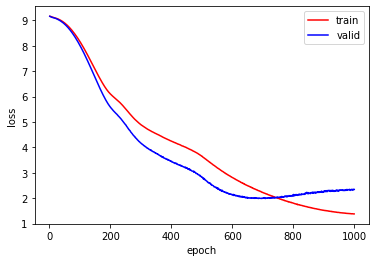

<Figure size 432x288 with 0 Axes>

In [39]:
x = np.arange(1, train_results.shape[0]+1)
plt.plot(x, train_results[:, 0], label='train', color='red')
plt.plot(x, valid_results[:, 0], label='valid', color='blue')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.savefig(opt.output_dir+'/loss.png')

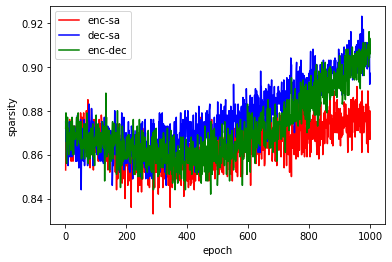

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(x, sparsity_results[:, 0], label='enc-sa', color='red')
plt.plot(x, sparsity_results[:, 1], label='dec-sa', color='blue')
plt.plot(x, sparsity_results[:, 2], label='enc-dec', color='green')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('sparsity')
plt.show()
plt.savefig(opt.output_dir+'/sparsity.png')